# Problem Breakdown

### Problem Statement: 
XYZ Company is a manufacturer of household cleaning products, operating across four different countries with an annual revenue of USD 800 million. Their manufacturing plant relies on over 30 industrial pumps to produce their range of detergents, shampoos, and other cleaning supplies. Recently, one of their pumps has failed unexpectedly seven times in the last six months, causing significant production losses estimated at USD 500,000, in addition to environmental damage caused by spilled toxic chemicals amounting to USD 300,000. To avoid such problems in the future, XYZ Company is keen to identify anomalies in pump behavior and take corrective action before the pump fails. By implementing a system that can detect and flag unusual pump behavior, the company aims to prevent any hard failures and minimize production losses and environmental damage.


### Problem Context: 
Manufacturing industry relies on heavy machinery, including motors, pumps, pipes, furnaces, and conveyors. Asset Management programs prioritize equipment integrity and reliability to avoid production losses, which can result in financial losses of hundreds of thousands or millions of dollars. Robust Asset Management frameworks, including skilled Reliability Engineers, can detect anomalies and prevent unplanned downtime, unnecessary maintenance, and critical component shortages. These prevention measures can save manufacturing plants significant financial losses due to unplanned downtime, maintenance costs, and excess or shortage of critical components

### Solution: 
Model with good accuracy score with zero rework


### Scope 
This project focuses solely on identifying anomalies in the 53 sensors of the chosen pump and does not encompass other pumps. It also does not involve predicting potential pump failures.


### Solution 
My approach involves creating a benchmark model using the IQR technique, and then implementing two other unsupervised learning algorithms to compare their performances and accuracies. To achieve this, I will undertake the following steps:

- Source and load the data 
- Perform data wrangling
- Conduct Exploratory Data Analysis (EDA)
- Carry out pre-processing and feature engineering
- Develop models: IQR and K-Means
- Evaluate the models: 

### Result of Analysis: 
Kmeans comes on top v/s IQR model with accuracy of 87.7% v/s 86.6%


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pump-sensor-data/sensor.csv


In [2]:
import pandas_profiling as pp
from pandas_profiling import ProfileReport
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer
import random

pd.options.display.max_columns = None

## Step 2 : Data Wrangling 

In [3]:
# I had checked the file first, I know that first row is the column headers and the first column is the index.
# Let's read it into a pandas dataframe
df = pd.read_csv(os.path.join(dirname, filename), index_col=0, header=0)

In [4]:
# Let's first do some data exploration and get some insights about data
# I, at first, used pandas profiling but over all the data set it took some much time and the output file was too big
# Therefore, I use the minimal calculations to get an insight. 
# But I will do manual EDA to show my reasoning. Therefore, I commented the python code below.
# Feel free to uncomment it at your interest

#profile = ProfileReport()
#profile = pp.ProfileReport(sensor_data, minimal=True)
#profile.to_file("output.minimal.html")

In [5]:
df.shape

(220320, 54)

In [6]:
# Let's get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

In [7]:
df.nunique()

timestamp         220320
sensor_00           1253
sensor_01            831
sensor_02            831
sensor_03            588
sensor_04           7844
sensor_05         190751
sensor_06            812
sensor_07            531
sensor_08            626
sensor_09            565
sensor_10         198804
sensor_11         196368
sensor_12         187145
sensor_13         191983
sensor_14          94564
sensor_15              0
sensor_16         110522
sensor_17         148000
sensor_18         152603
sensor_19         100422
sensor_20          92129
sensor_21         131083
sensor_22         126401
sensor_23         119286
sensor_24         133778
sensor_25         165999
sensor_26         179718
sensor_27         203198
sensor_28         189278
sensor_29         201908
sensor_30           2070
sensor_31           2685
sensor_32         205414
sensor_33         200855
sensor_34         203895
sensor_35         201781
sensor_36         201437
sensor_37         188898
sensor_38            602


In [8]:
# Let's count the unique values of one of the columns
df['machine_status'].value_counts(dropna=False).head()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

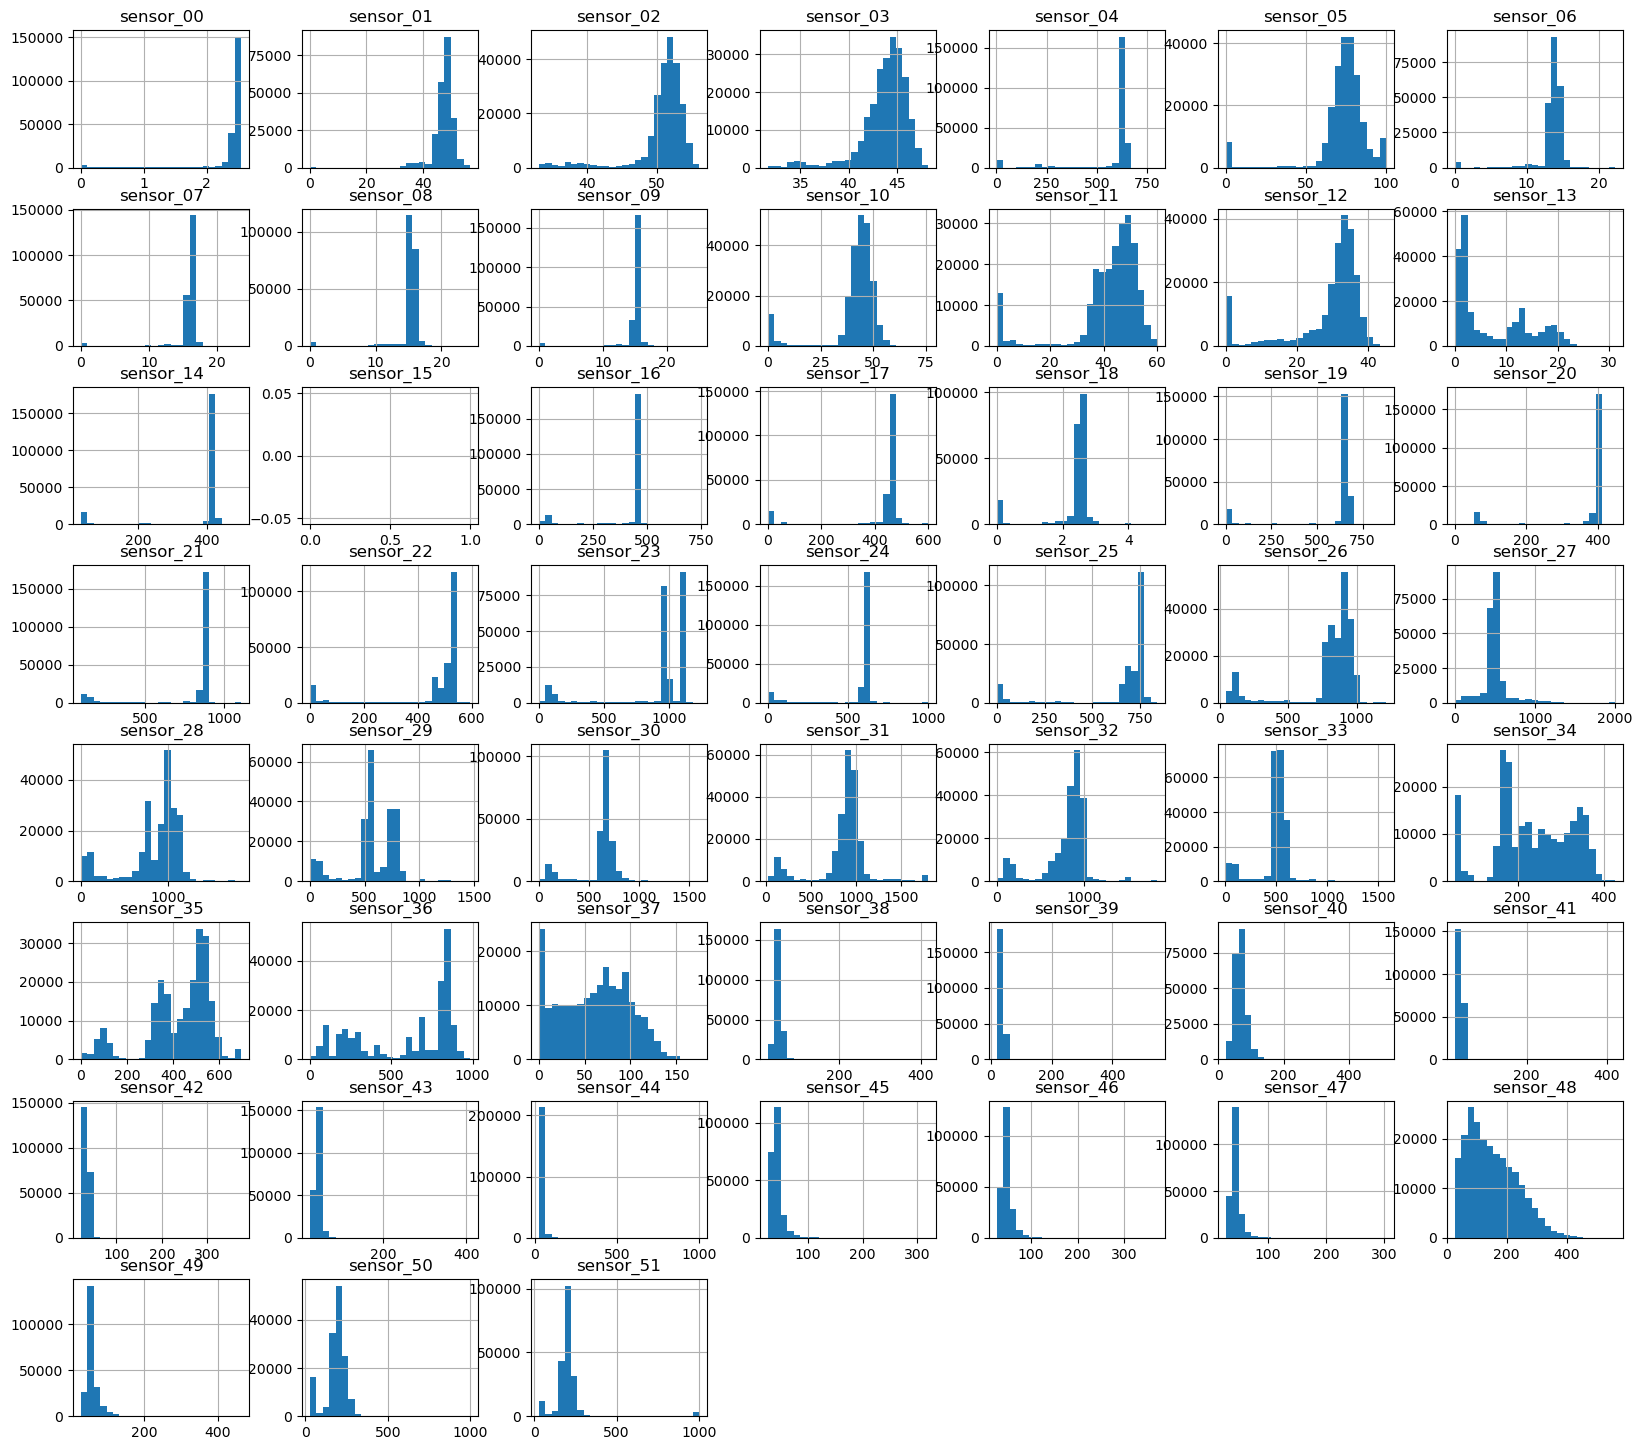

In [9]:
# Histogram
df.hist(df.columns, bins=25, layout=(8,7), figsize=(20, 18))
plt.show()

## Clean the data
- Remove redundant columns
- Remove duplicates
- Handle missing values
- Convert data types to the correct data type
Keep in mind: there are data formats that are better for reporting vs. better for analysis; tidy data makes it easier to fix common data problems

In [10]:
# Drop duplicates
df = df.drop_duplicates()
# Entire "sensor_15" column is NaN therefore removing the entire column from the data set
del df['sensor_15']

df.shape

(220320, 53)

In [11]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

# Let's take a look at top ten columns with missing values
calc_percent_NAs(df).head(10)

percent
sensor_50  0.349569
sensor_51  0.069821
sensor_00  0.046333
sensor_07  0.024741
sensor_08  0.023180
sensor_06  0.021777
sensor_09  0.020856
sensor_01  0.001675
sensor_30  0.001185
sensor_29  0.000327

In [12]:
#Lets fill Let's fill NAs in columns sensor_50, sensor_51, sensor_00, sensor_07, sensor_08, sensor_06 and sensor_09 with their mean values

df['sensor_50'].fillna((df['sensor_50'].mean()), inplace=True)
df['sensor_51'].fillna((df['sensor_51'].mean()), inplace=True)
df['sensor_00'].fillna((df['sensor_00'].mean()), inplace=True)
df['sensor_08'].fillna((df['sensor_08'].mean()), inplace=True)
df['sensor_07'].fillna((df['sensor_07'].mean()), inplace=True)
df['sensor_06'].fillna((df['sensor_06'].mean()), inplace=True)
df['sensor_09'].fillna((df['sensor_09'].mean()), inplace=True)


In [13]:
df_tidy = df.dropna()

In [14]:
# Let's convert the data type of timestamp column to datatime format
import warnings
warnings.filterwarnings("ignore")
df_tidy['date'] = pd.to_datetime(df_tidy['timestamp'])
del df_tidy['timestamp']

df_tidy = df_tidy.set_index('date')
df_tidy.head()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
date                                                                         
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
date                                                                         
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  \
date                                                                         
2018-04-01 00:00:00   37.22740   47.52422   31.11716   1.681353   419.5747   
2018-04-01 00:01:00   37.22740   47.52422   31.11716   1.681353   419.5747   
2018-04-01 00:02:00   37.86777   48.17723   32.08894   1.708474   420.8480   
2018-04-01 00:03:00   38.57977   48.65607   31.67221   1.579427   420.7494   
2018-04-01 00:04:00   39.48939   49.06298   31.95202   1.683831   419.8926   

                     sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
date                                                                         
2018-04-01 00:00:00   461.8781   466.3284   2.565284   665.3993   398.9862   
2018-04-01 00:01:00   461.8781   466.3284   2.565284   665.3993   398.9862   
2018-04-01 00:02:00   462.7798   459.6364   2.500062   666.2234   399.9418   
2018-04-01 00:03:00   462.8980   460.8858   2.509521   666.0114   399.1046   
2018-04-01 00:04:00   461.4906   468.2206   2.604785   663.2111   400.5426   

                     sensor_21  sensor_22  sensor_23  sensor_24  sensor_25  \
date                                                                         
2018-04-01 00:00:00   880.0001   498.8926   975.9409   627.6740   741.7151   
2018-04-01 00:01:00   880.0001   498.8926   975.9409   627.6740   741.7151   
2018-04-01 00:02:00   880.4237   501.3617   982.7342   631.1326   740.8031   
2018-04-01 00:03:00   878.8917   499.0430   977.7520   625.4076   739.2722   
2018-04-01 00:04:00   882.5874   498.5383   979.5755   627.1830   737.6033   

                     sensor_26  sensor_27  sensor_28  sensor_29  sensor_30  \
date                                                                         
2018-04-01 00:00:00   848.0708   429.0377   785.1935   684.9443   594.4445   
2018-04-01 00:01:00   848.0708   429.0377   785.1935   684.9443   594.4445   
2018-04-01 00:02:00   849.8997   454.2390   778.5734   715.6266   661.5740   
2018-04-01 00:03:00   847.7579   474.8731   779.5091   690.4011   686.1111   
2018-04-01 00:04:00   846.9182   408.8159   785.2307   704.6937   631.4814   

                     sensor_31  sensor_32  sensor_33  sensor_34  sensor_35  \
date                                                                         
2018-04-01 00:00:00   682.8125   680.4416   433.7037   171.9375   341.9039   
2018-04-01 00:01:00   682.8125   680.4416   433.7037   171.9375   341.9039   
2018-04-01 00:02:00   721.8750   694.7721   441.2635   169.9820   343.1955   
2018-04-01 00:03:00   754.6875   683.3831   446.2493   166.4987   343.9586   
2018-04-01 00:04:00   766.1458   702.4431   433.9081   164.7498   339.9630   

                     sensor_36  sensor_37  sensor_38  sensor_39  sensor_40  \
date                                                                         
2018-04-01 00:00:00   195.0655   90.

## Exploratory Data Analysis 

In [15]:
df = df_tidy
df.head()


sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
date                                                                         
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
date                                                                         
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  \
date                                                                         
2018-04-01 00:00:00   37.22740   47.52422   31.11716   1.681353   419.5747   
2018-04-01 00:01:00   37.22740   47.52422   31.11716   1.681353   419.5747   
2018-04-01 00:02:00   37.86777   48.17723   32.08894   1.708474   420.8480   
2018-04-01 00:03:00   38.57977   48.65607   31.67221   1.579427   420.7494   
2018-04-01 00:04:00   39.48939   49.06298   31.95202   1.683831   419.8926   

                     sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
date                                                                         
2018-04-01 00:00:00   461.8781   466.3284   2.565284   665.3993   398.9862   
2018-04-01 00:01:00   461.8781   466.3284   2.565284   665.3993   398.9862   
2018-04-01 00:02:00   462.7798   459.6364   2.500062   666.2234   399.9418   
2018-04-01 00:03:00   462.8980   460.8858   2.509521   666.0114   399.1046   
2018-04-01 00:04:00   461.4906   468.2206   2.604785   663.2111   400.5426   

                     sensor_21  sensor_22  sensor_23  sensor_24  sensor_25  \
date                                                                         
2018-04-01 00:00:00   880.0001   498.8926   975.9409   627.6740   741.7151   
2018-04-01 00:01:00   880.0001   498.8926   975.9409   627.6740   741.7151   
2018-04-01 00:02:00   880.4237   501.3617   982.7342   631.1326   740.8031   
2018-04-01 00:03:00   878.8917   499.0430   977.7520   625.4076   739.2722   
2018-04-01 00:04:00   882.5874   498.5383   979.5755   627.1830   737.6033   

                     sensor_26  sensor_27  sensor_28  sensor_29  sensor_30  \
date                                                                         
2018-04-01 00:00:00   848.0708   429.0377   785.1935   684.9443   594.4445   
2018-04-01 00:01:00   848.0708   429.0377   785.1935   684.9443   594.4445   
2018-04-01 00:02:00   849.8997   454.2390   778.5734   715.6266   661.5740   
2018-04-01 00:03:00   847.7579   474.8731   779.5091   690.4011   686.1111   
2018-04-01 00:04:00   846.9182   408.8159   785.2307   704.6937   631.4814   

                     sensor_31  sensor_32  sensor_33  sensor_34  sensor_35  \
date                                                                         
2018-04-01 00:00:00   682.8125   680.4416   433.7037   171.9375   341.9039   
2018-04-01 00:01:00   682.8125   680.4416   433.7037   171.9375   341.9039   
2018-04-01 00:02:00   721.8750   694.7721   441.2635   169.9820   343.1955   
2018-04-01 00:03:00   754.6875   683.3831   446.2493   166.4987   343.9586   
2018-04-01 00:04:00   766.1458   702.4431   433.9081   164.7498   339.9630   

                     sensor_36  sensor_37  sensor_38  sensor_39  sensor_40  \
date                                                                         
2018-04-01 00:00:00   195.0655   90.

### Quantative EDA

In [16]:
# Quantative EDA
df.describe().T

count        mean         std        min         25%  \
sensor_00  219521.0    2.371961    0.403223   0.000000    2.417187   
sensor_01  219521.0   47.590015    3.299447   0.000000   46.310760   
sensor_02  219521.0   50.863387    3.668355  33.159720   50.390620   
sensor_03  219521.0   43.746718    2.417856  31.640620   42.838539   
sensor_04  219521.0  590.629672  144.127709   2.798032  626.620400   
sensor_05  219521.0   73.397642   17.304487   0.000000   69.982320   
sensor_06  219521.0   13.500351    2.143252   0.014468   13.346350   
sensor_07  219521.0   15.841237    2.176726   0.000000   15.856480   
sensor_08  219521.0   15.198273    2.015901   0.028935   15.183740   
sensor_09  219521.0   14.796988    2.072470   0.000000   15.010130   
sensor_10  219521.0   41.461726   12.102394   0.000000   40.700760   
sensor_11  219521.0   41.908190   13.066915   0.000000   38.842180   
sensor_12  219521.0   29.133358   10.118714   0.000000   28.680340   
sensor_13  219521.0    7.080832    6.906261   0.000000    1.536424   
sensor_14  219521.0  377.224967  112.717758  32.409550  418.128300   
sensor_16  219521.0  416.897999  125.454450   0.000000  459.487300   
sensor_17  219521.0  421.565602  128.519412   0.000000  454.184700   
sensor_18  219521.0    2.306220    0.762721   0.000000    2.448115   
sensor_19  219521.0  591.498440  198.441299   0.000000  662.795500   
sensor_20  219521.0  361.143866  101.519113   0.000000  398.035600   
sensor_21  219521.0  796.963480  225.726772  95.527660  875.497700   
sensor_22  219521.0  460.250858  153.894024   0.000000  479.043700   
sensor_23  219521.0  923.474036  290.704608   0.000000  950.972400   
sensor_24  219521.0  556.851052  181.458419   0.000000  601.182100   
sensor_25  219521.0  649.766530  220.084270   0.000000  694.086100   
sensor_26  219521.0  787.013592  245.756447  43.154790  791.955000   
sensor_27  219521.0  499.945115  162.443507   0.000000  448.248300   
sensor_28  219521.0  852.418041  312.275671   4.319347  783.033600   
sensor_29  219521.0  576.815388  225.356514   0.636574  519.112000   
sensor_30  219521.0  614.688802  195.652698   0.000000  627.777800   
sensor_31  219521.0  864.121286  282.849223  23.958330  839.583300   
sensor_32  219521.0  804.927785  259.841094   0.240716  761.666600   
sensor_33  219521.0  486.843044  150.266418   6.460602  489.847300   
sensor_34  219521.0  235.066491   88.181545  54.882370  172.566100   
sensor_35  219521.0  427.471956  141.461187   0.000000  353.394300   
sensor_36  219521.0  593.529842  289.080921   2.260970  289.071700   
sensor_37  219521.0   60.728412   37.596595   0.000000   28.717770   
sensor_38  219521.0   49.645540   10.551226  24.479166   45.572910   
sensor_39  219521.0   36.604566   15.638946  19.270830   32.552080   
sensor_40  219521.0   68.858892   21.398408  23.437500   57.812500   
sensor_41  219521.0   35.356642    7.908832  20.833330   32.552080   
sensor_42  219521.0   35.445976   10.275169  22.135416   32.812500   
sensor_43  219521.0   43.878502   11.061115  24.479166   39.583330   
sensor_44  219521.0   42.650970   11.592033  25.752316   36.747684   
sensor_45  219521.0   43.085801   12.852025  26.331018   36.747684   
sensor_46  219521.0   48.012455   15.657217  26.331018   40.509258   
sensor_47  219521.0   44.327382   10.448843  27.199070   39.062500   
sensor_48  219521.0  150.901538   82.332042  26.331018   83.622690   
sensor_49  219521.0   57.121069   19.170952  26.620370   47.743060   
sensor_50  219521.0  183.016279   52.671229  27.488426  182.581000   
sensor_51  219521.0  202.719224  105.868122  27.777779  180.555600   

                  50%          75%          max  
sensor_00    2.455556     2.499826     2.549016  
sensor_01   48.133678    49.479160    56.727430  
sensor_02   51.649300    52.777770    56.032990  
sensor_03   44.227428    45.225693    48.220490  
sensor_04  632.754600   637.615723   800.000000  
sensor_05   75.578420    80.918750    99.999880  
sensor_06   13.628470  

### Graphical EDA
Let's visualize the sensor readings across the entire 52 sensors and mark the pump's broken state in red color on the same graph

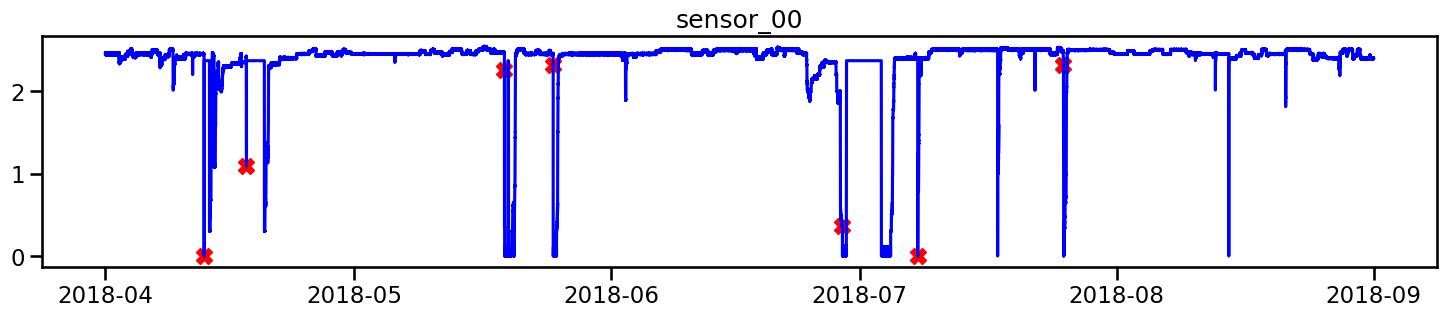

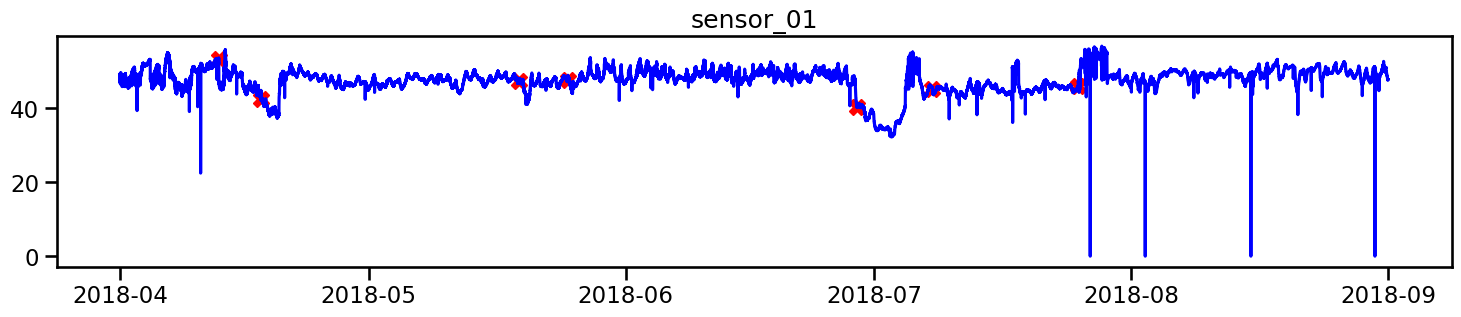

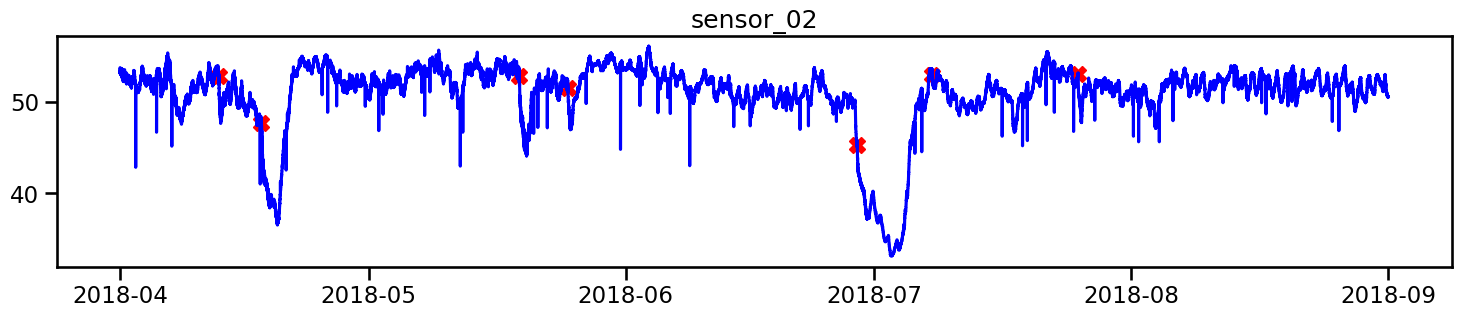

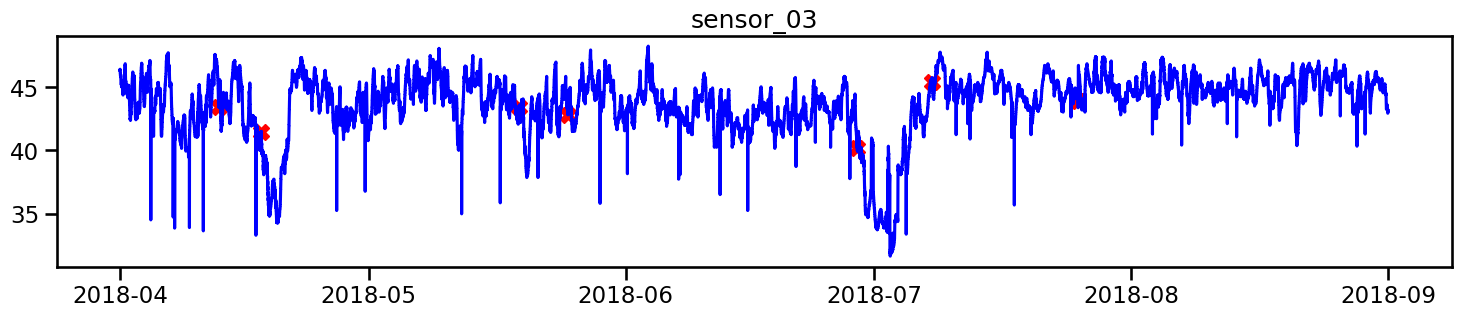

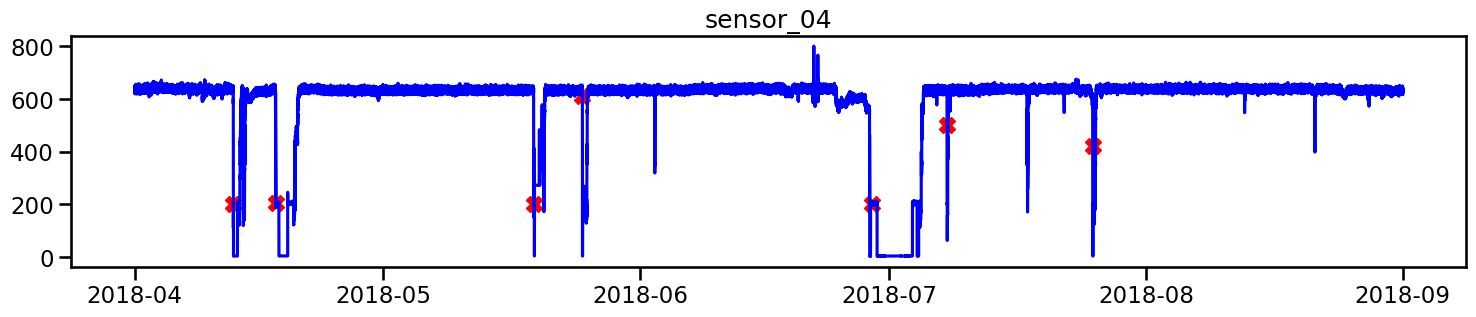

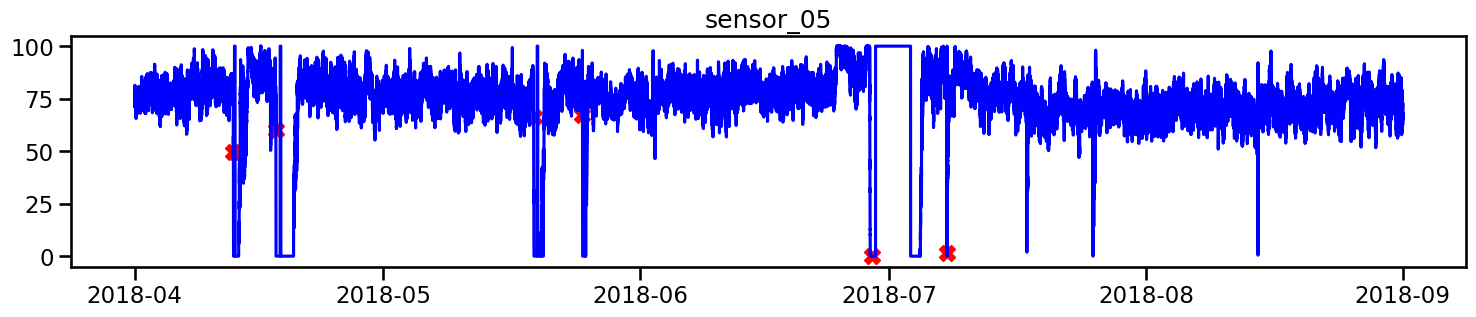

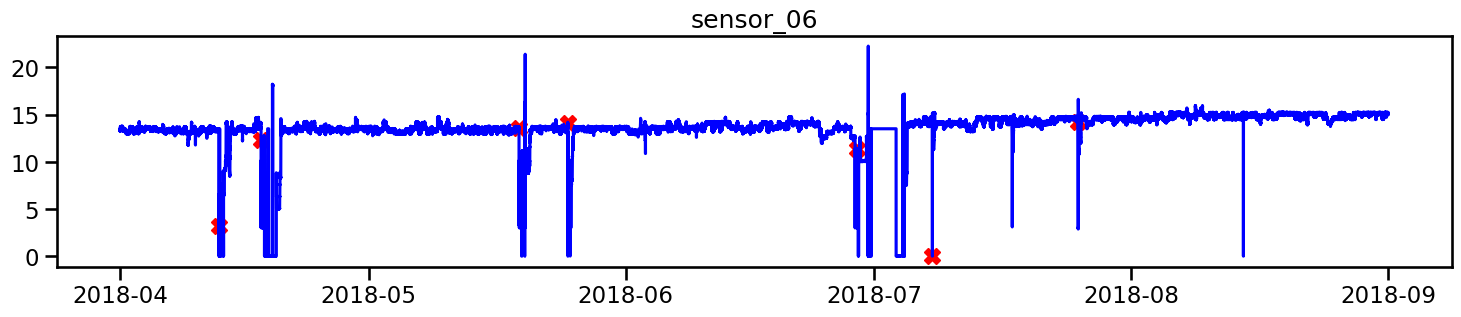

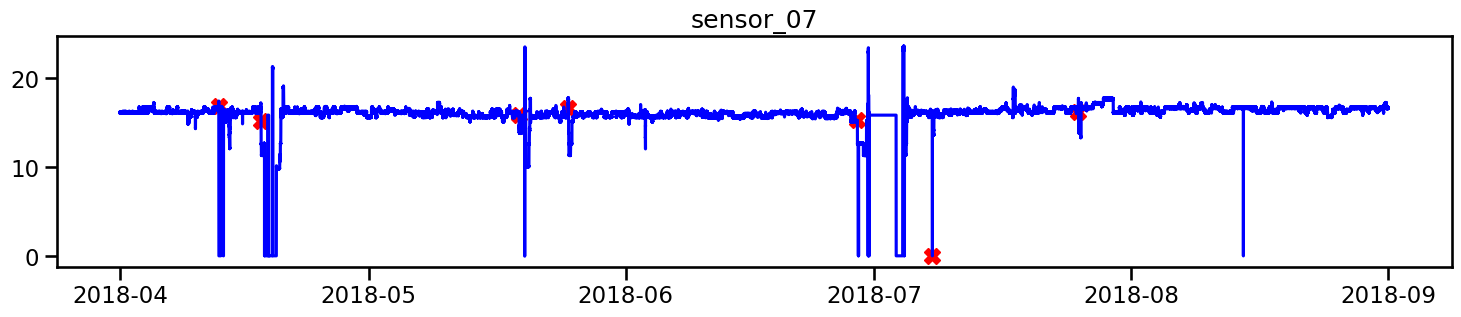

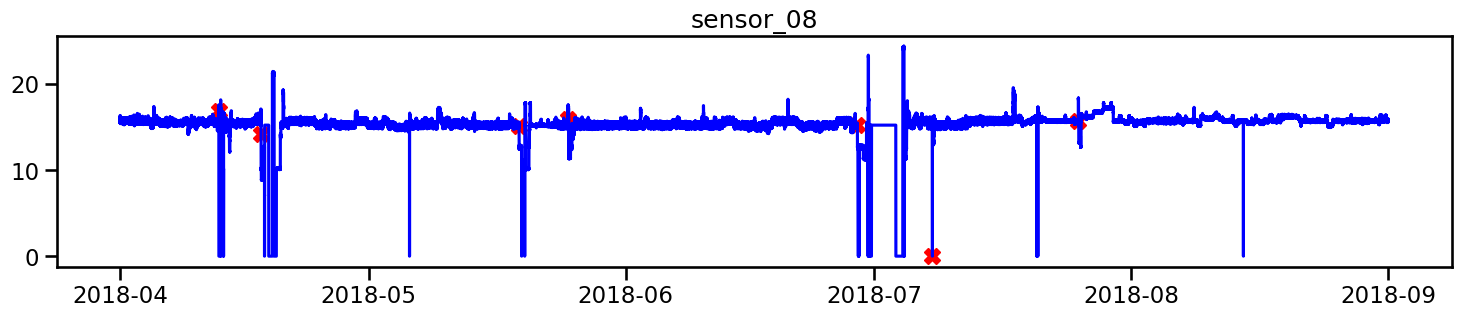

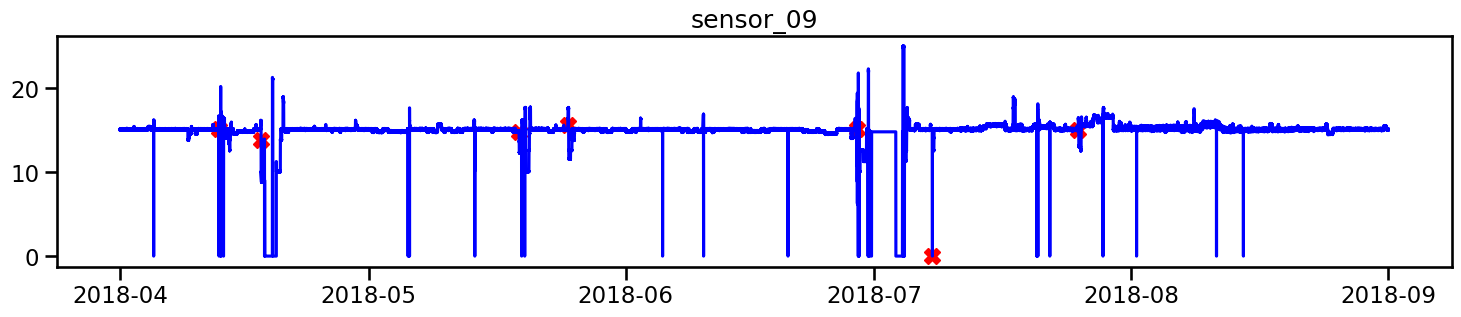

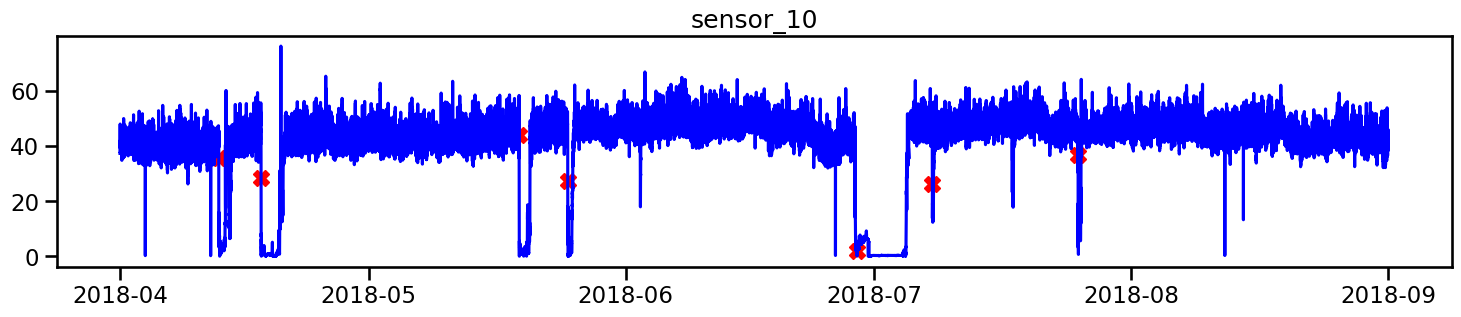

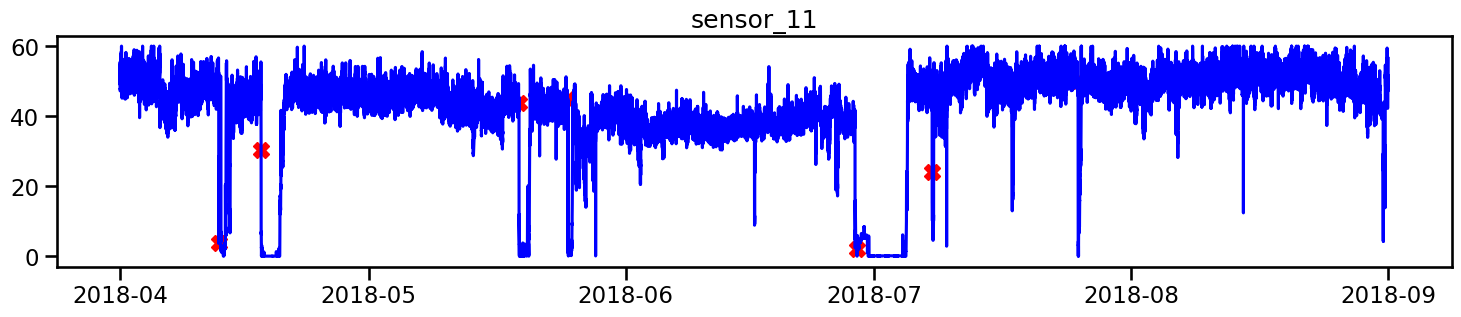

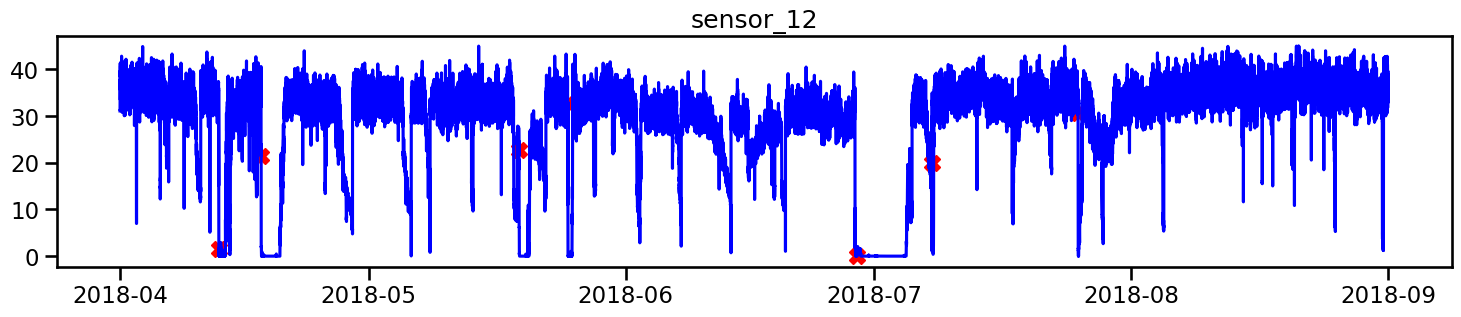

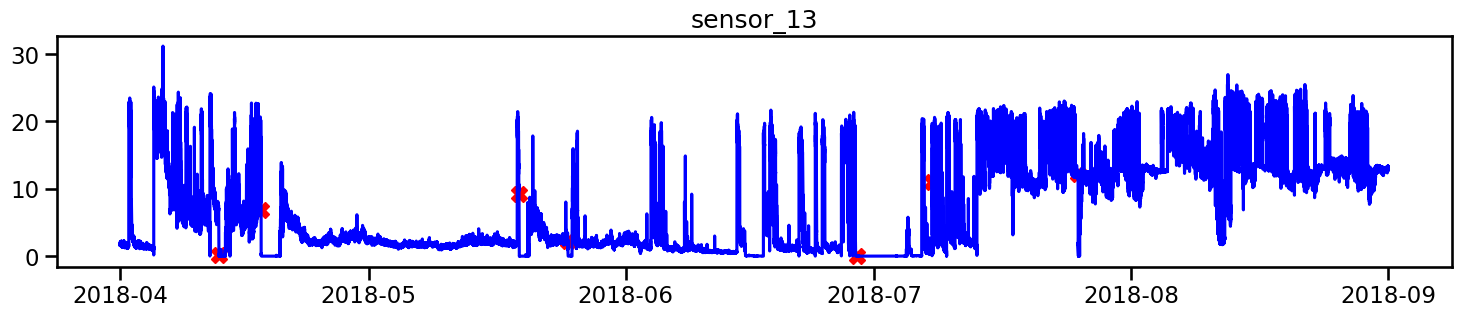

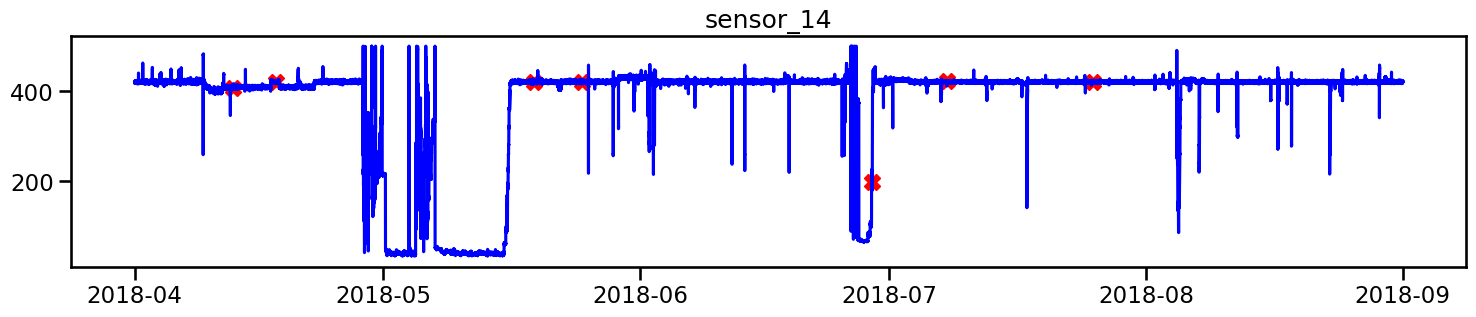

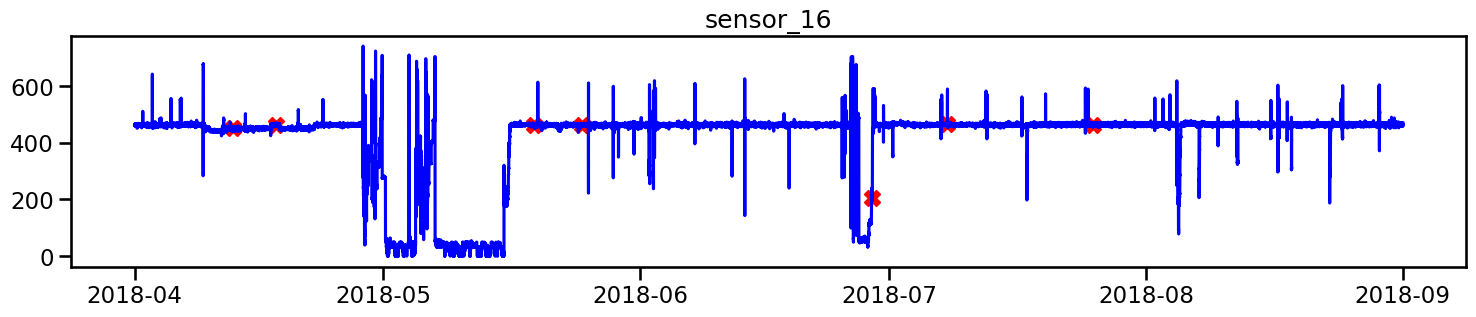

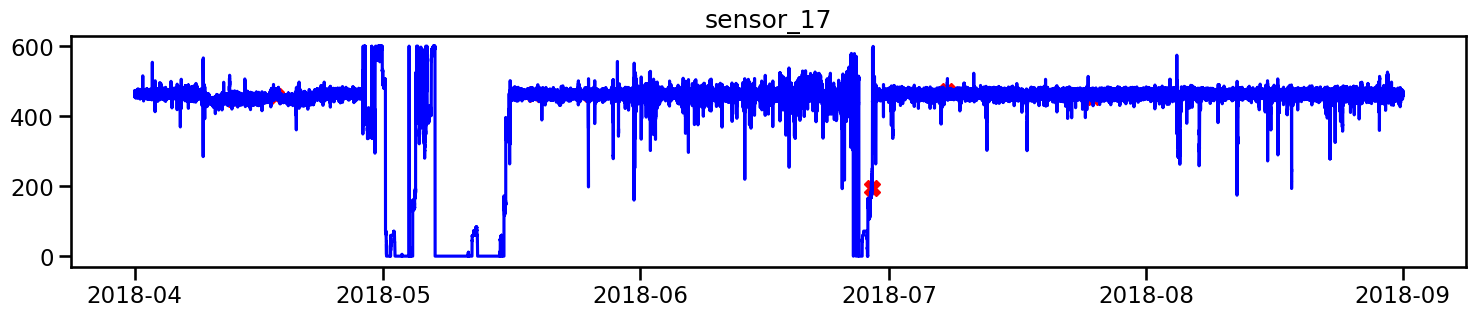

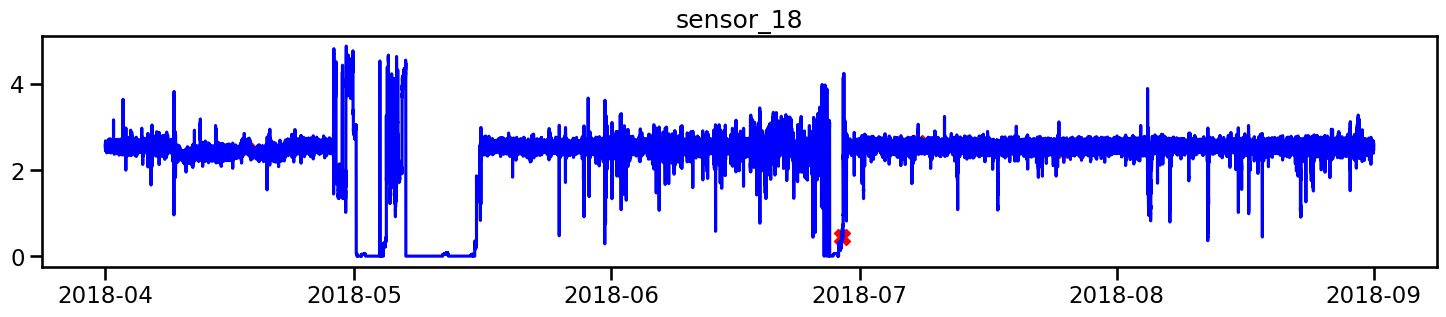

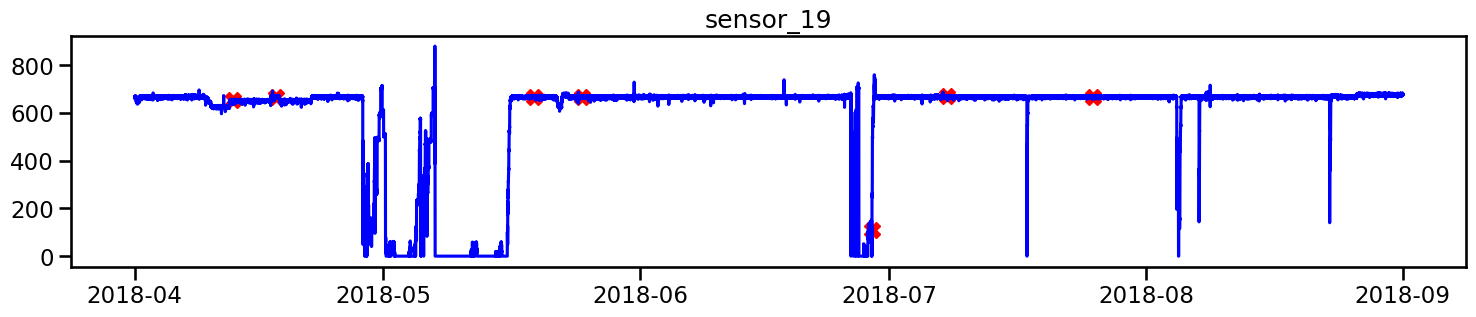

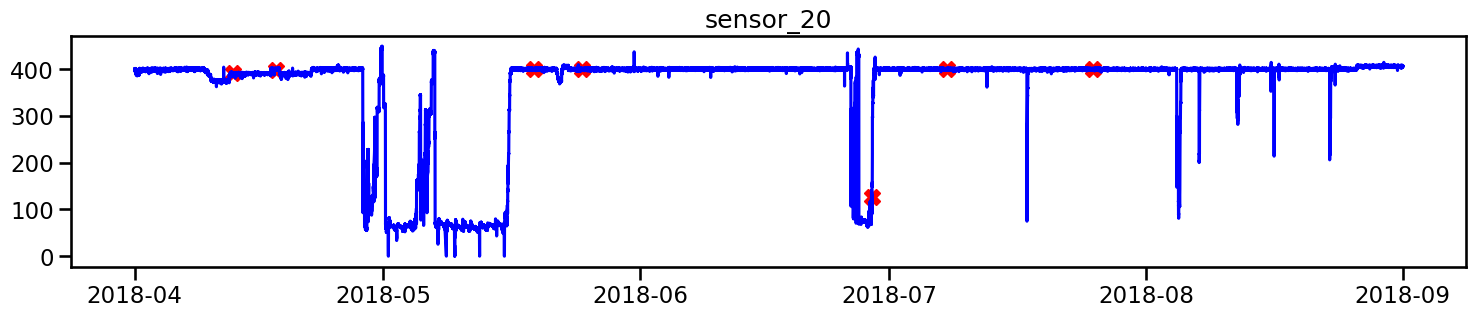

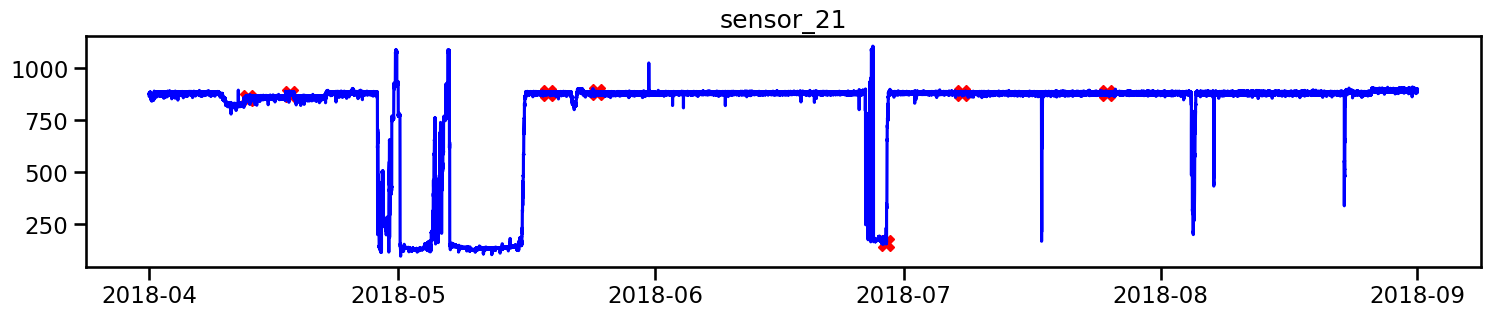

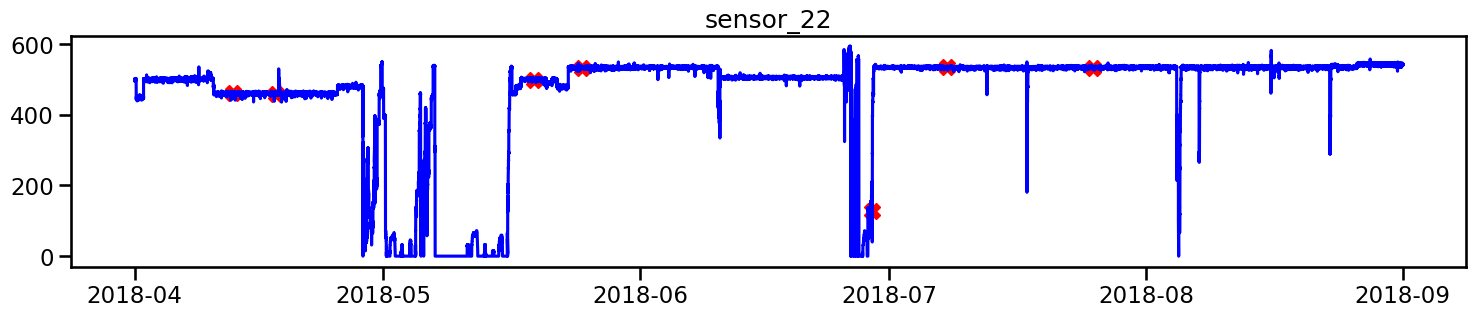

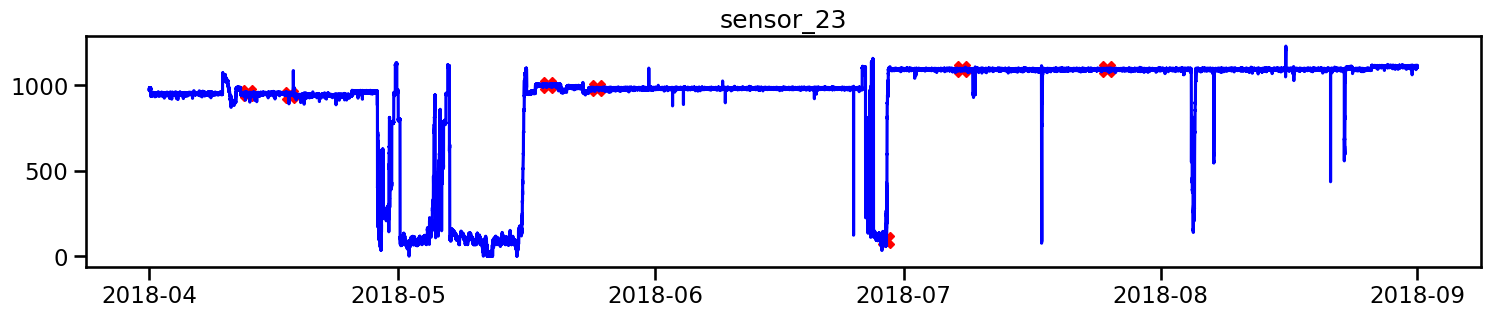

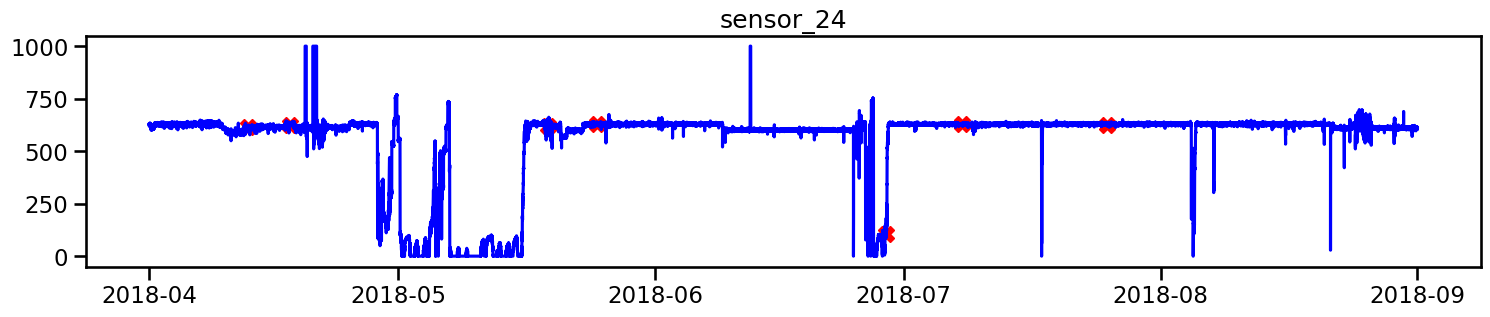

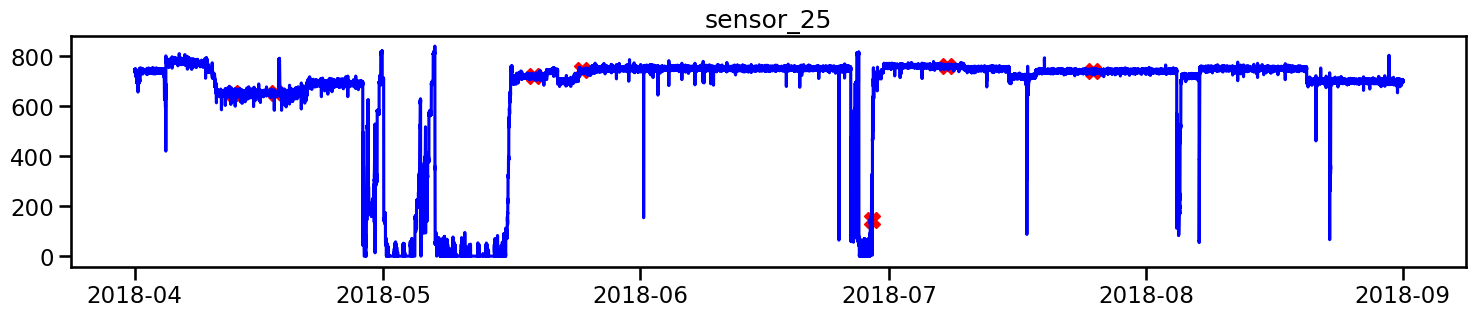

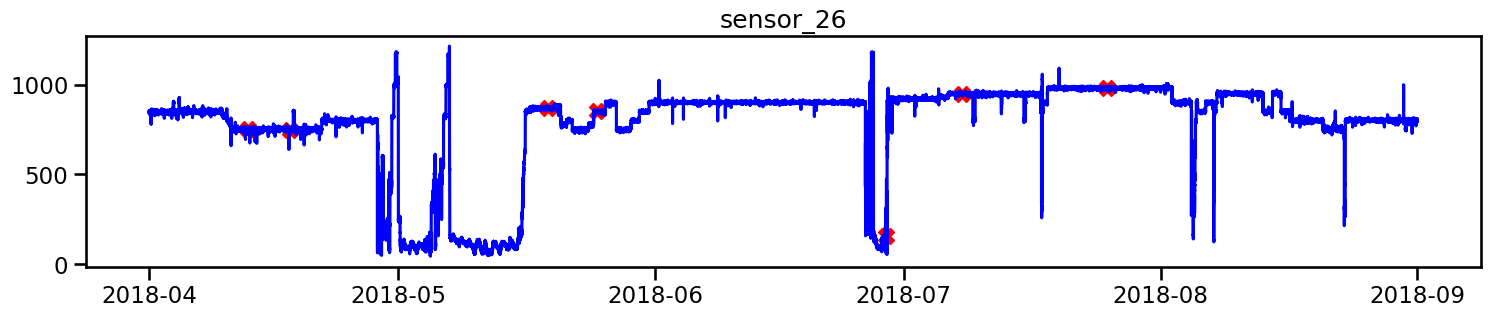

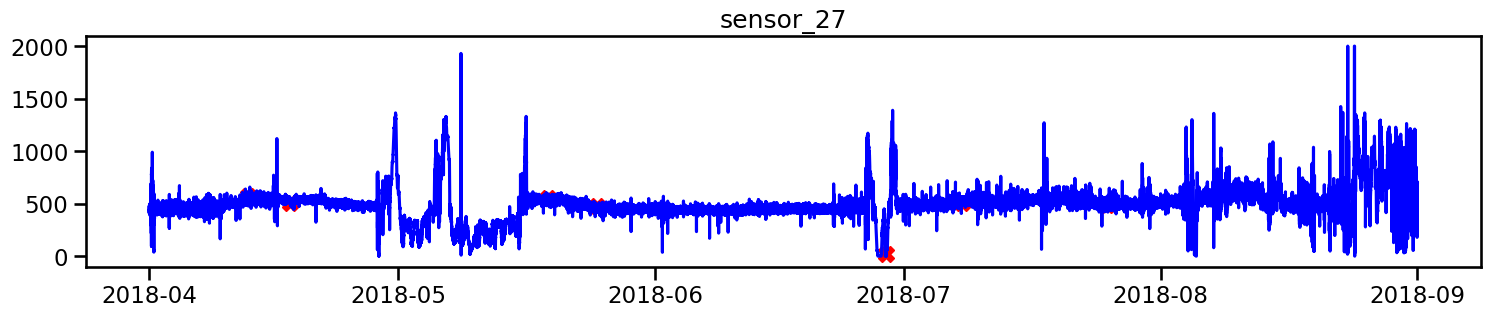

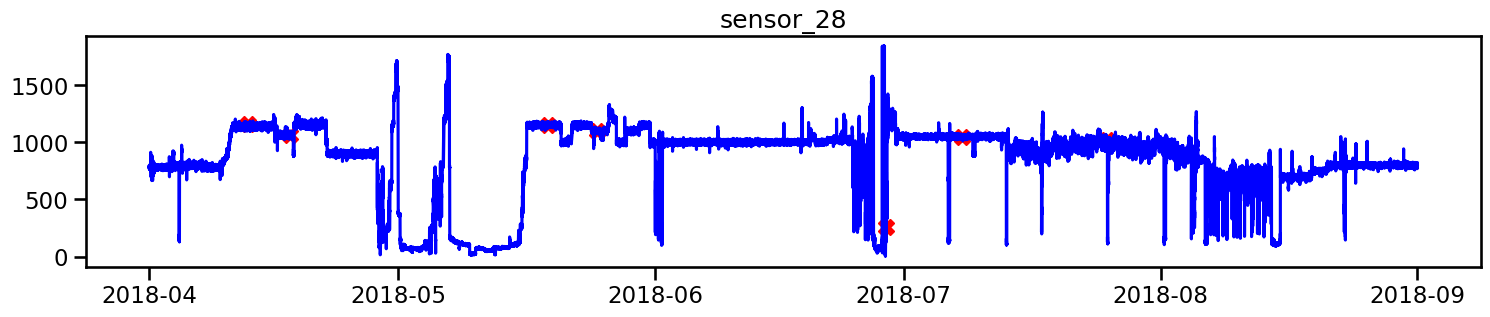

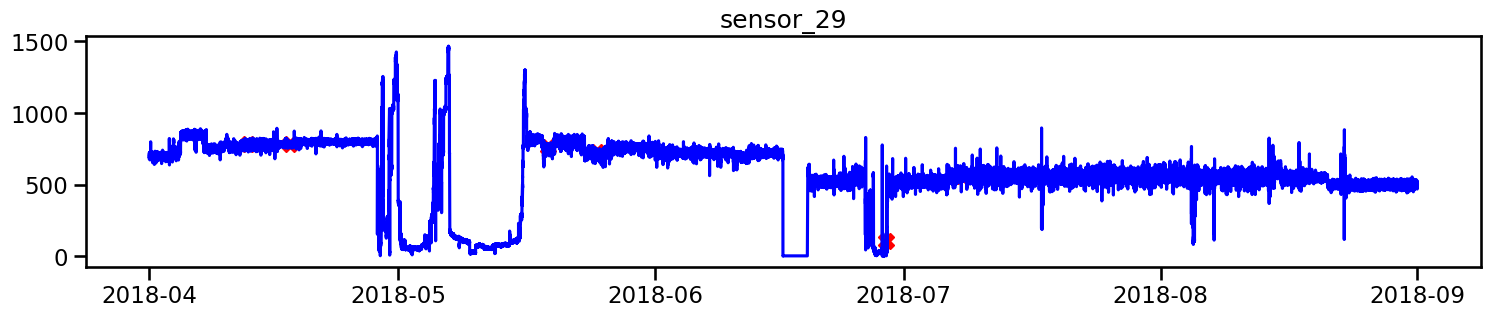

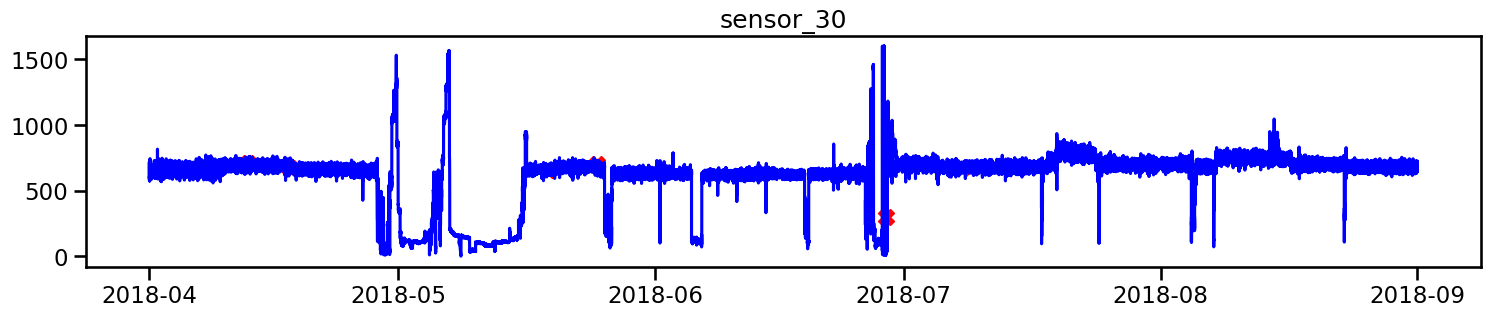

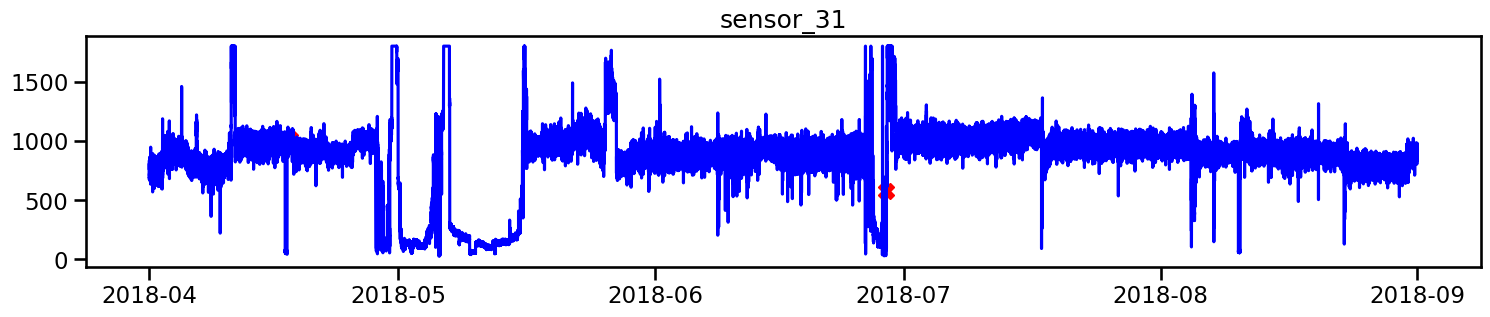

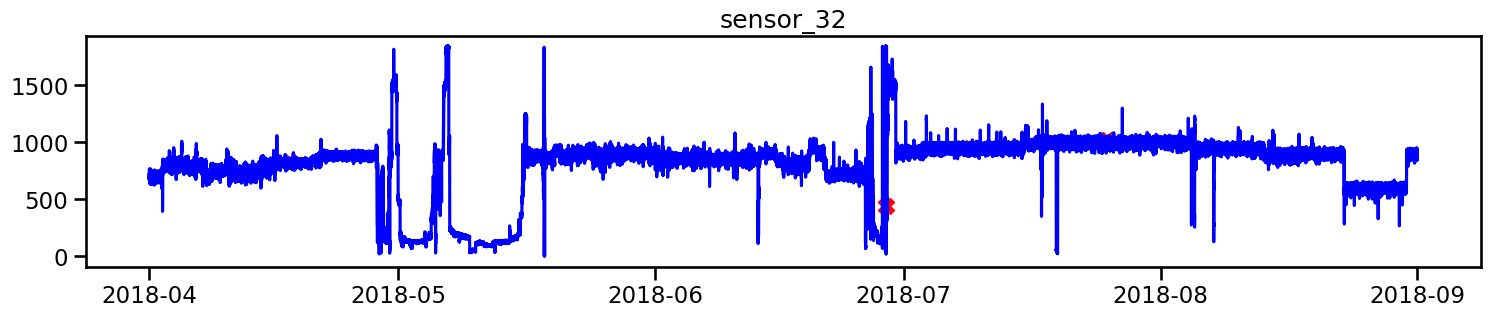

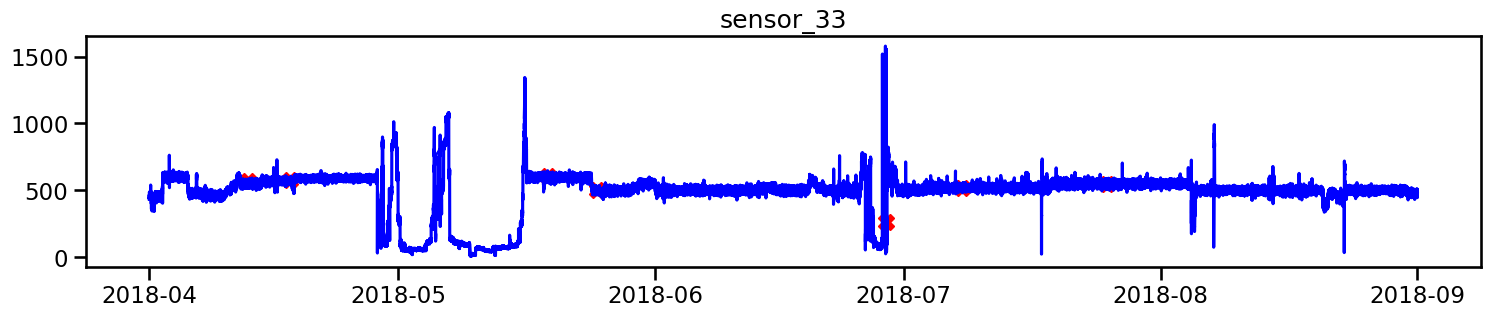

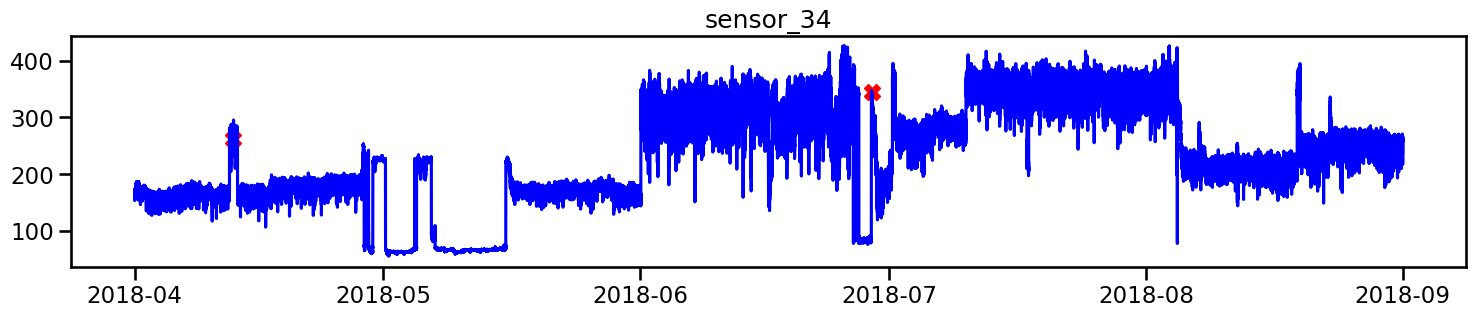

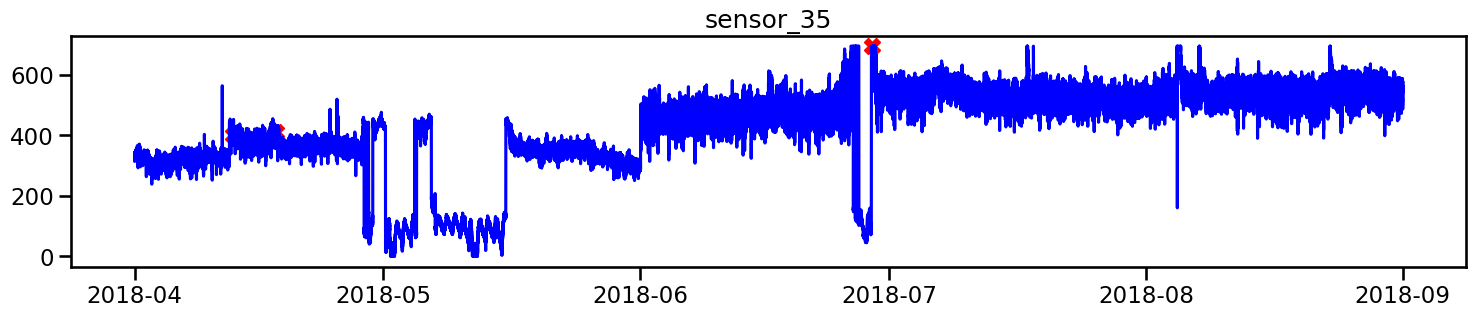

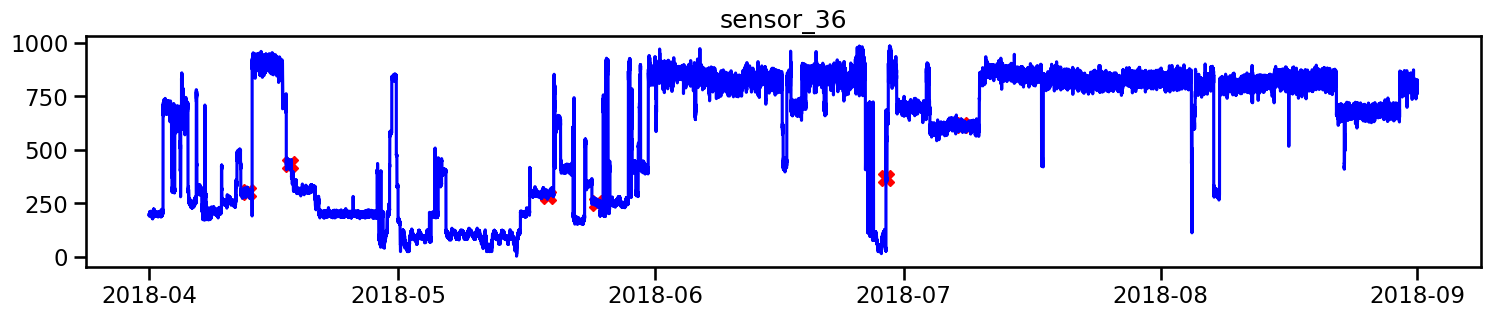

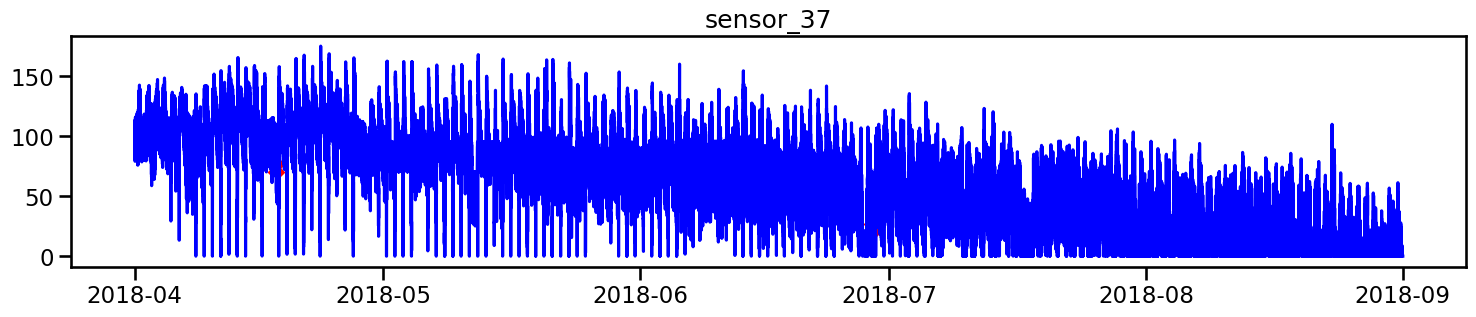

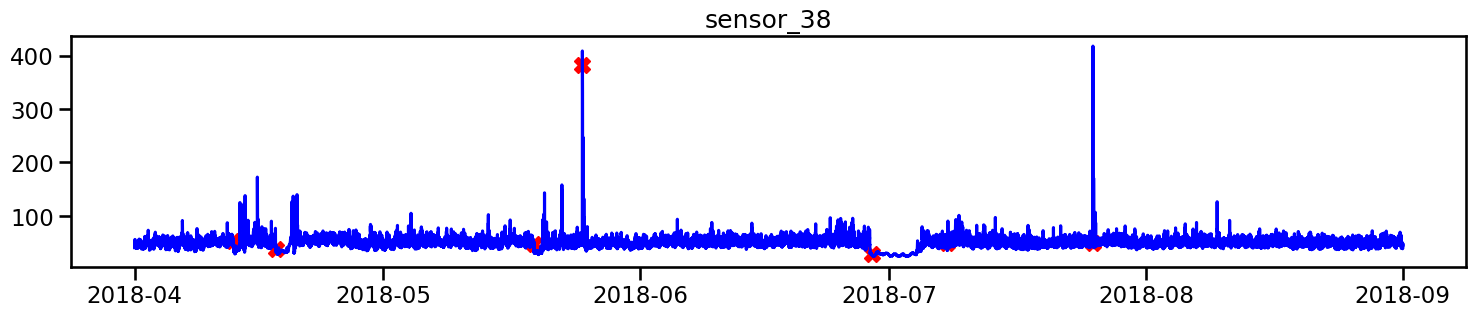

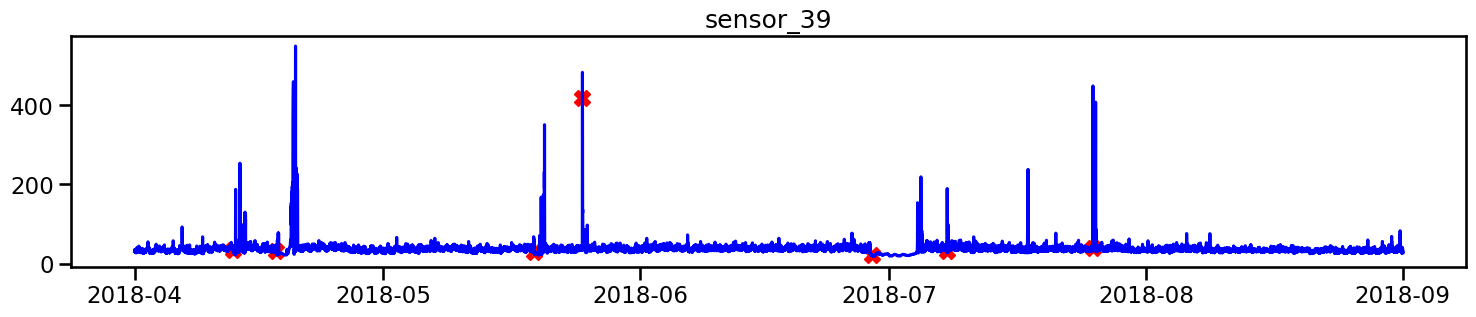

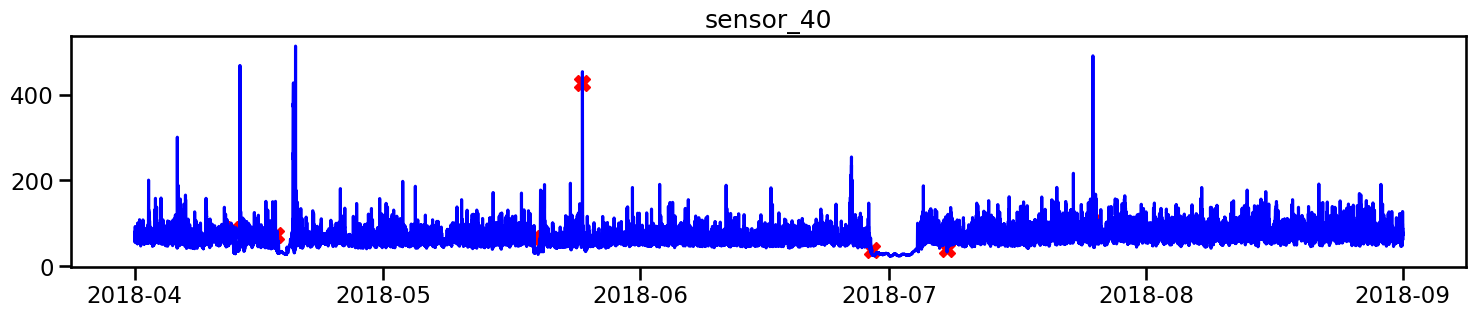

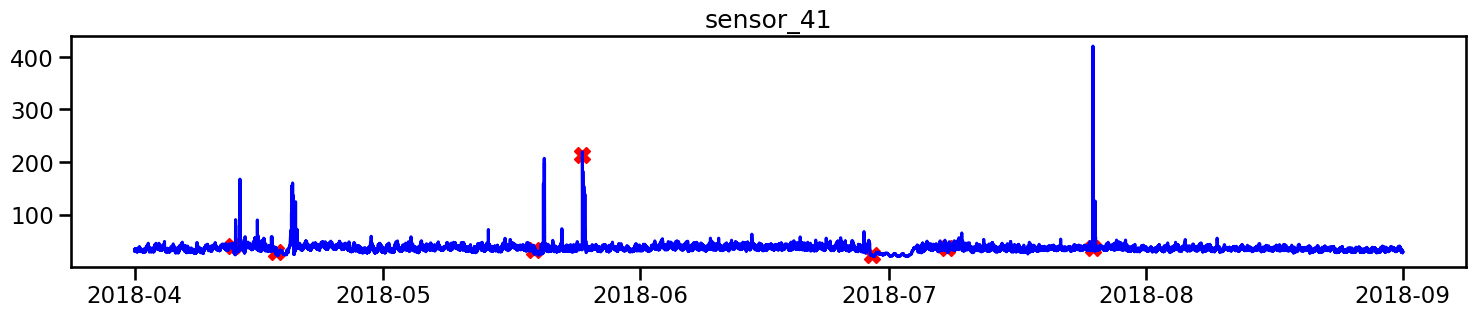

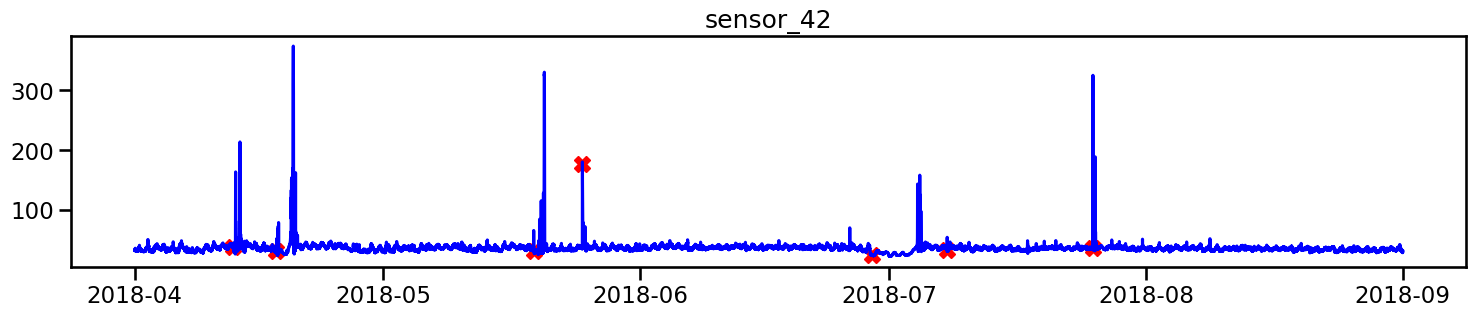

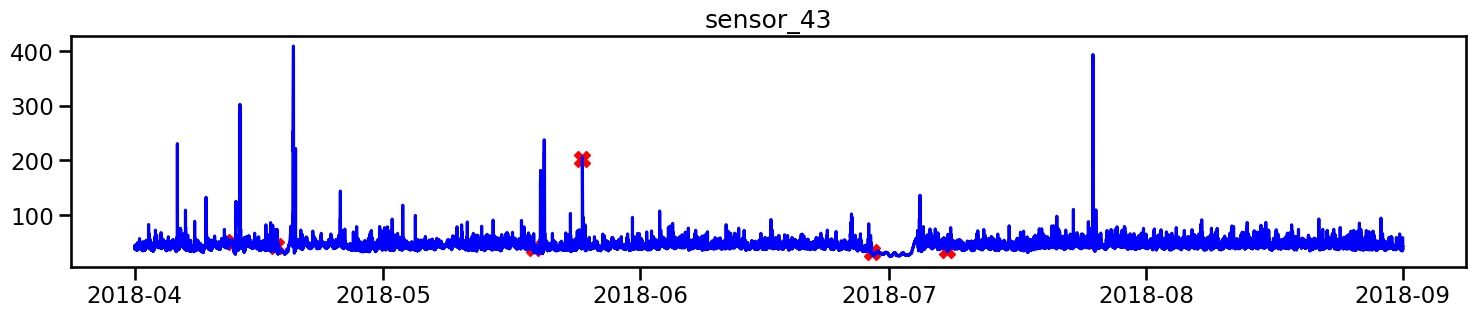

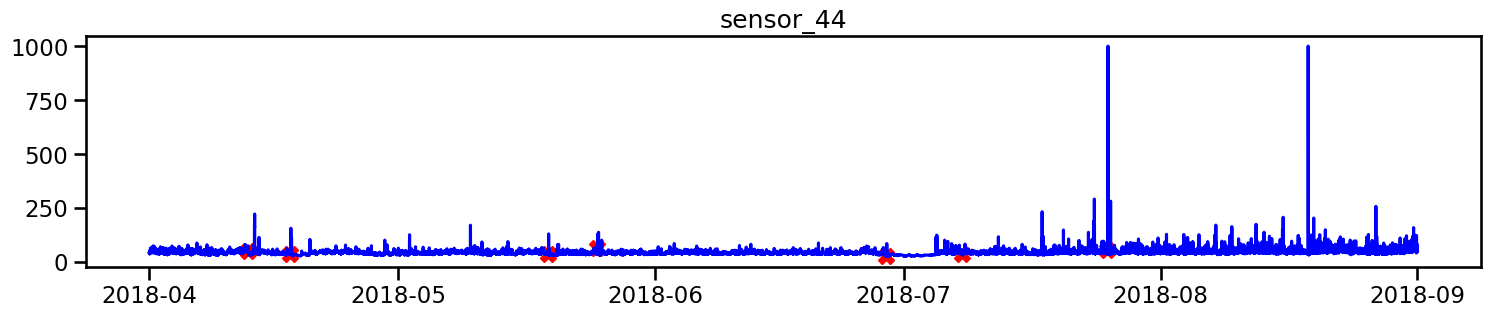

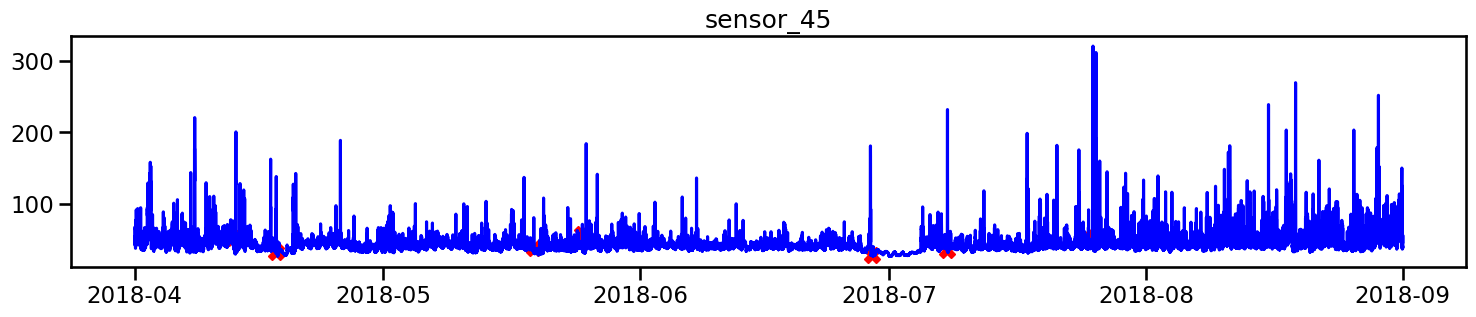

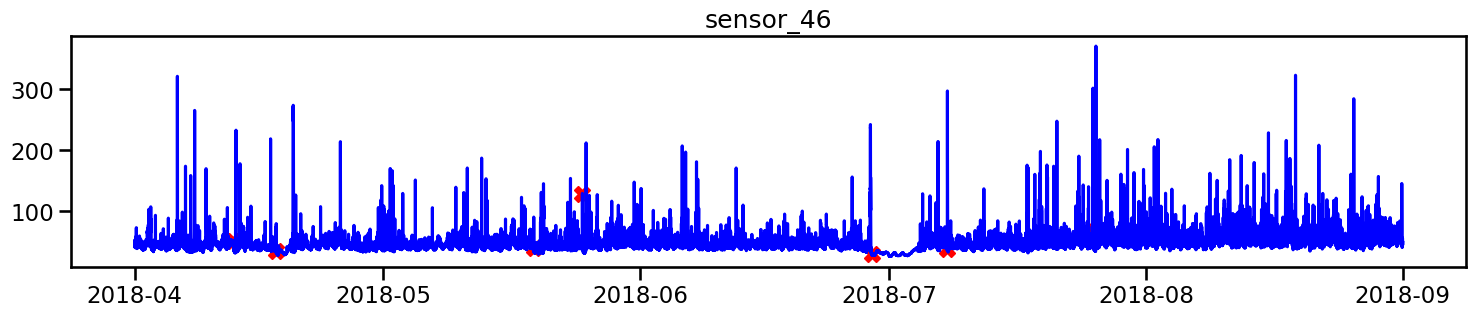

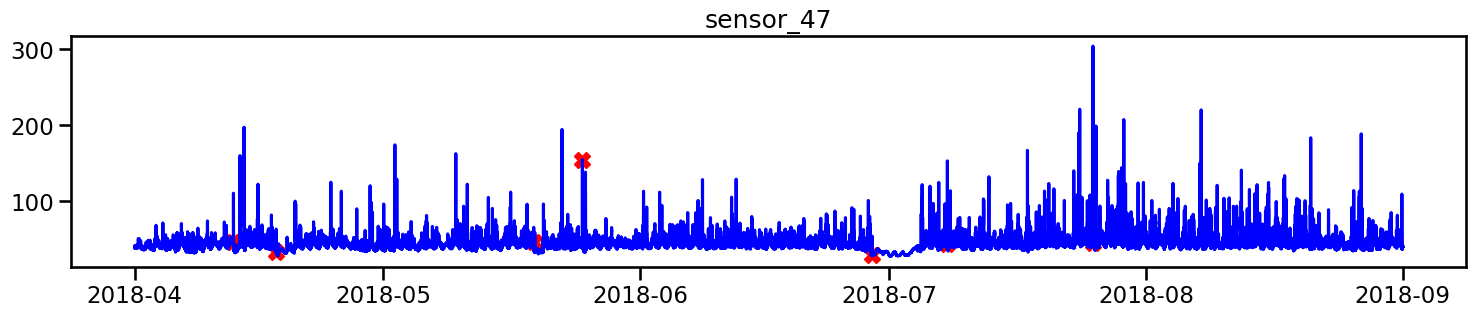

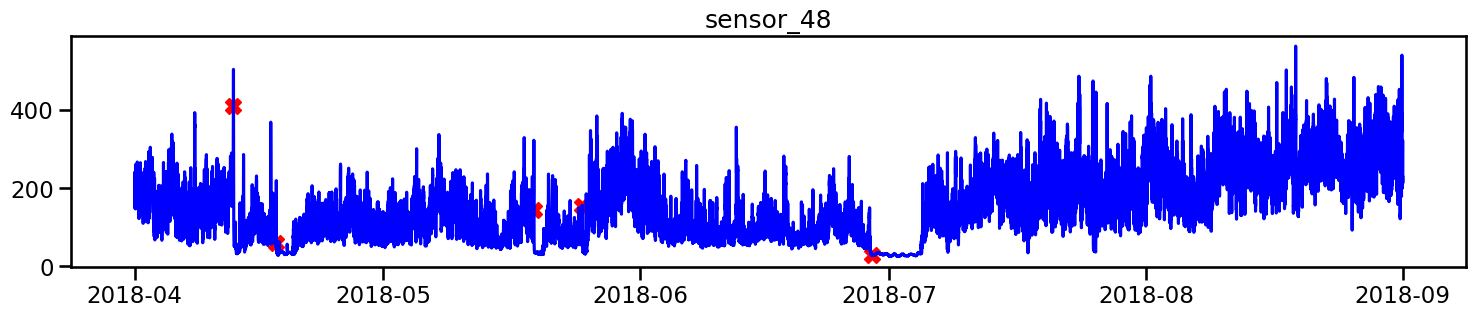

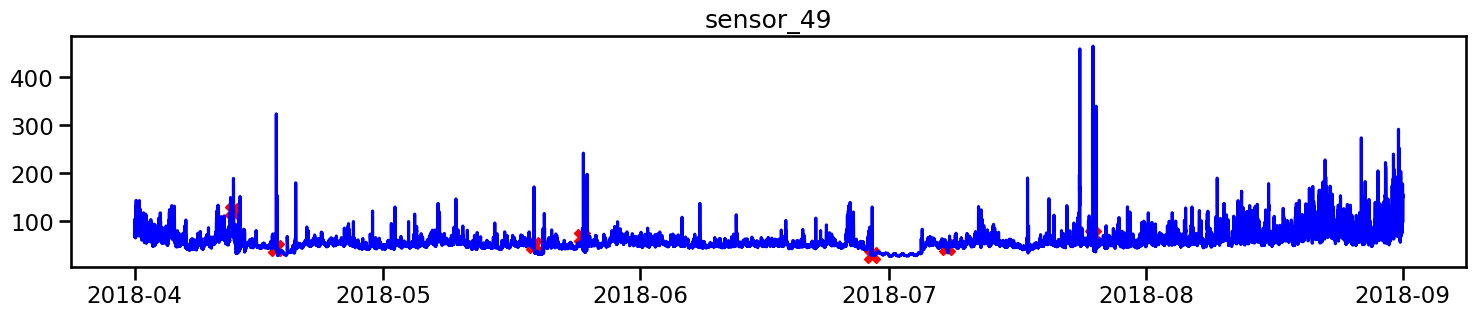

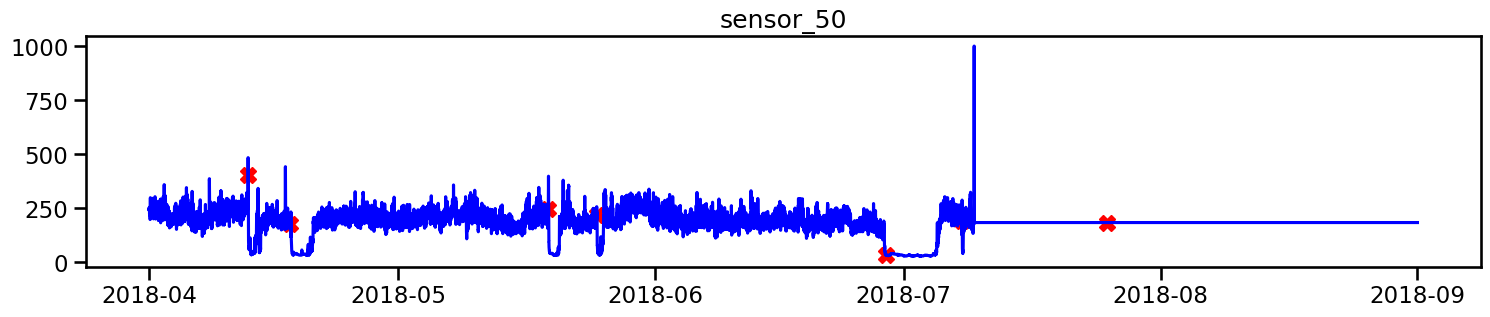

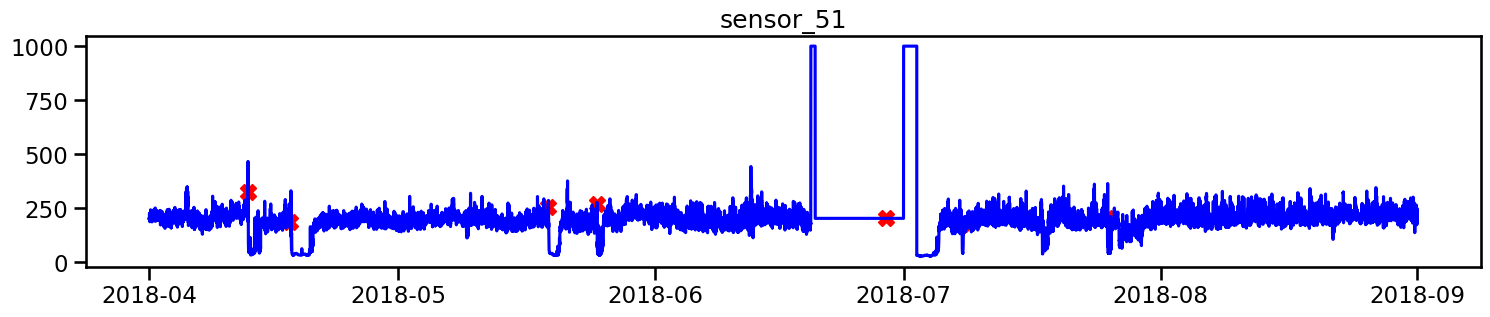

In [17]:
# Vizualize time series and the BROKEN state (red dots) in the same graph for each sensor
import warnings
# Extract the readings from BROKEN state and resample by daily average
broken = df[df['machine_status']=='BROKEN']
# Extract the names of the numerical columns
df2 = df.drop(['machine_status'], axis=1)
names=df2.columns
# Plot time series for each sensor with BROKEN state marked with X in red color
for name in names:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.plot(df[name], color='blue')
    _ = plt.title(name)
    plt.show()

### Check Stationarity with rolling stats

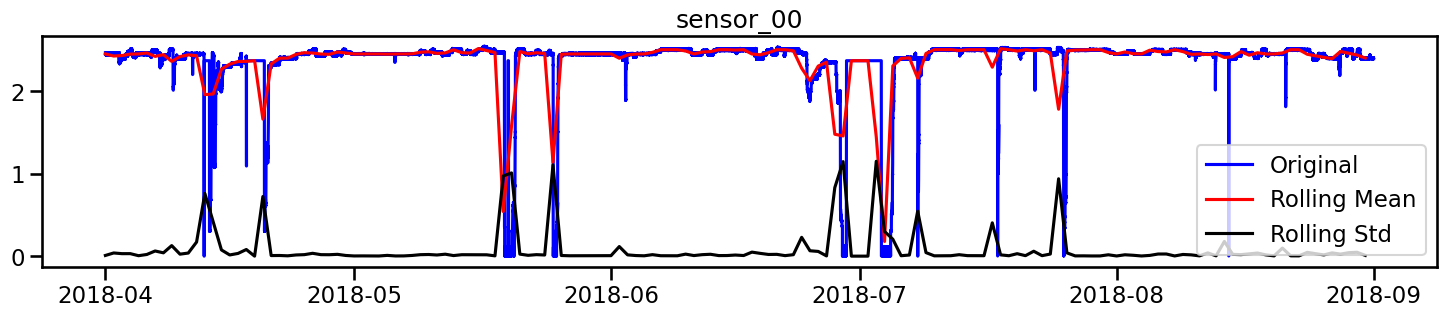

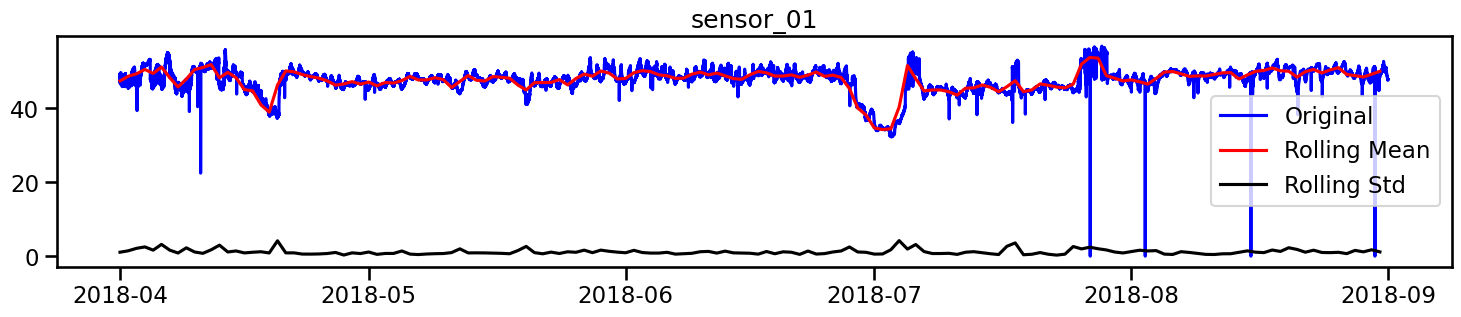

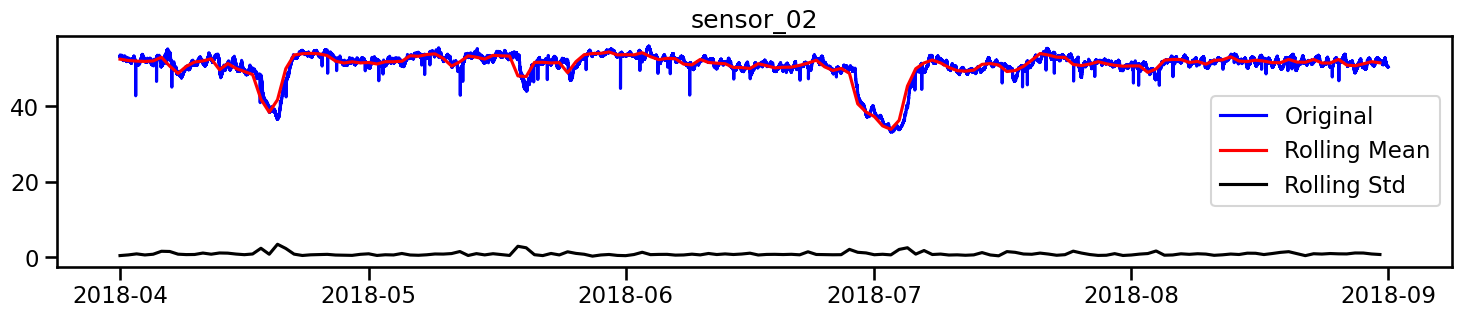

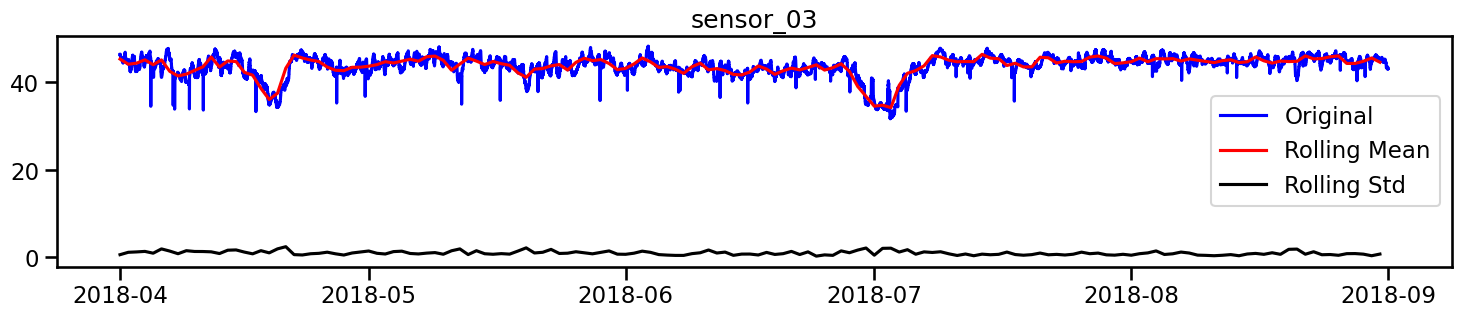

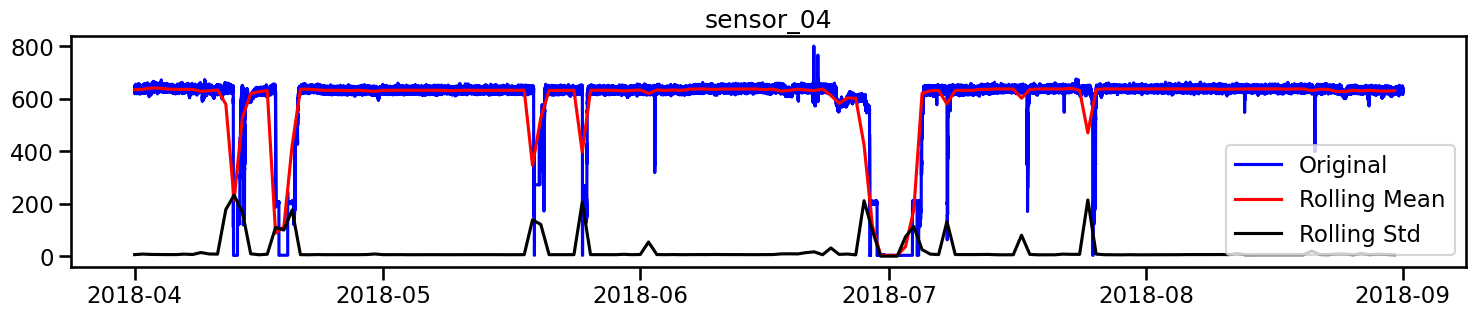

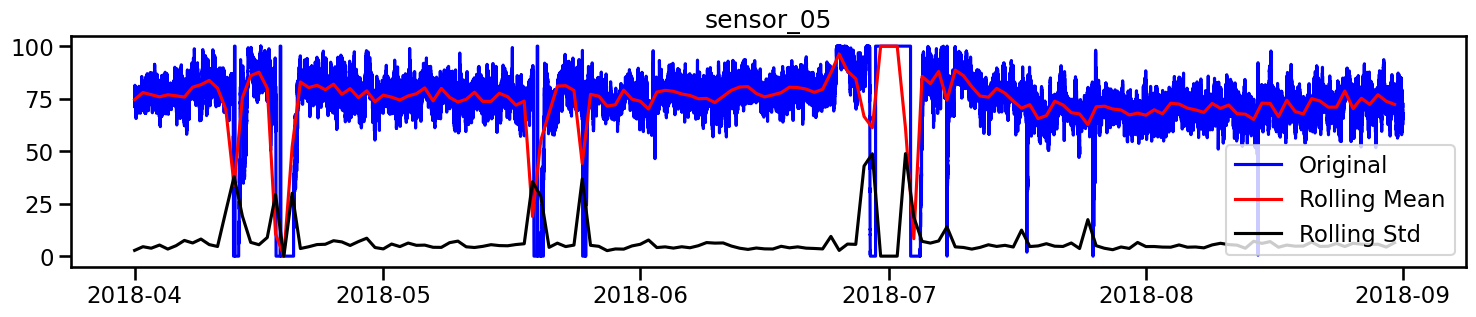

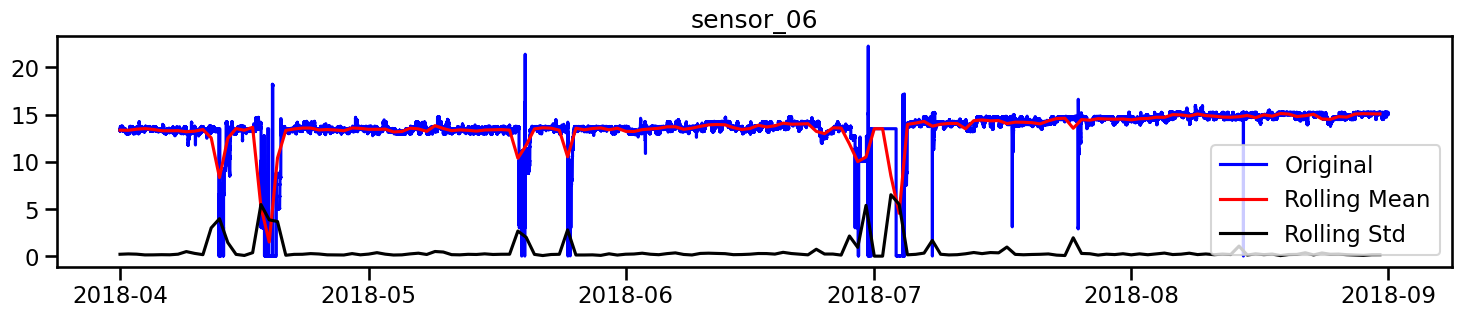

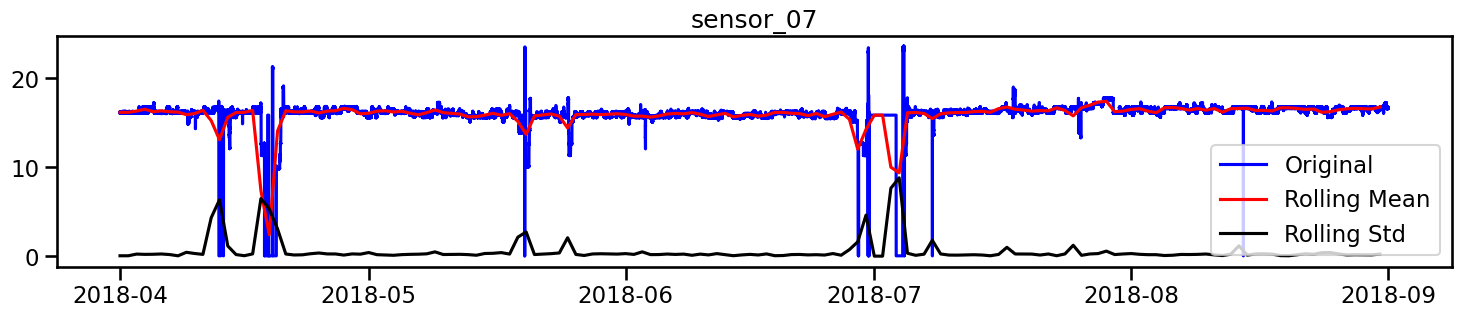

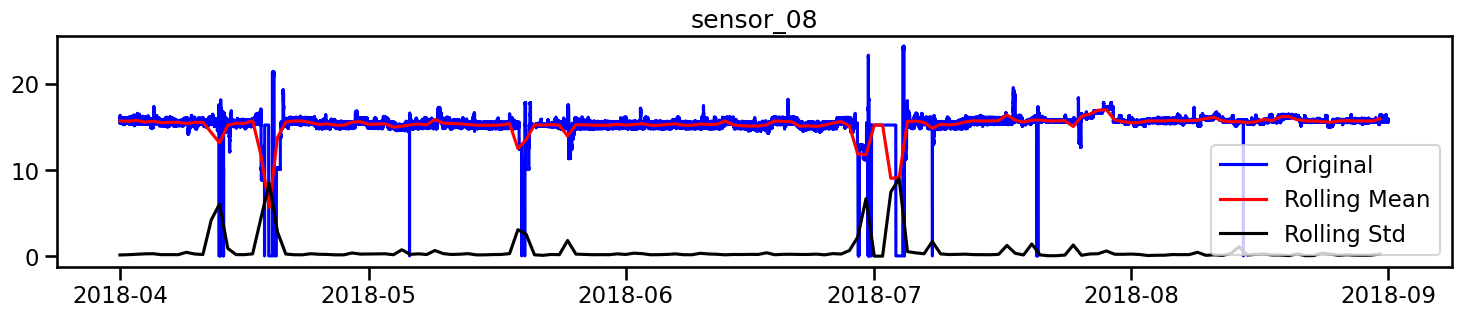

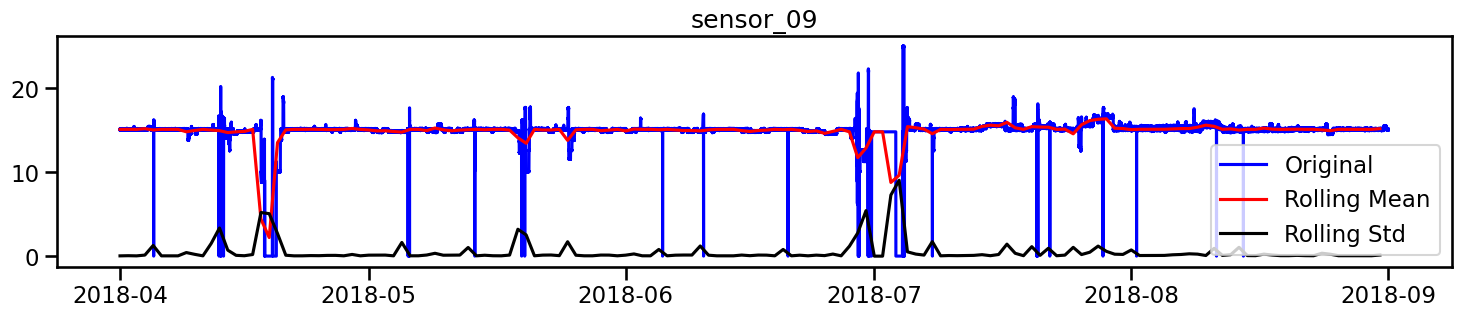

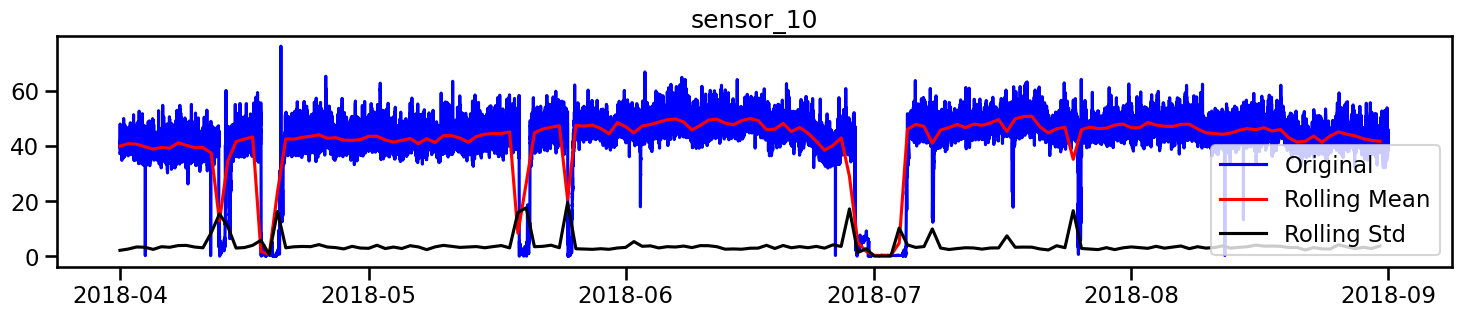

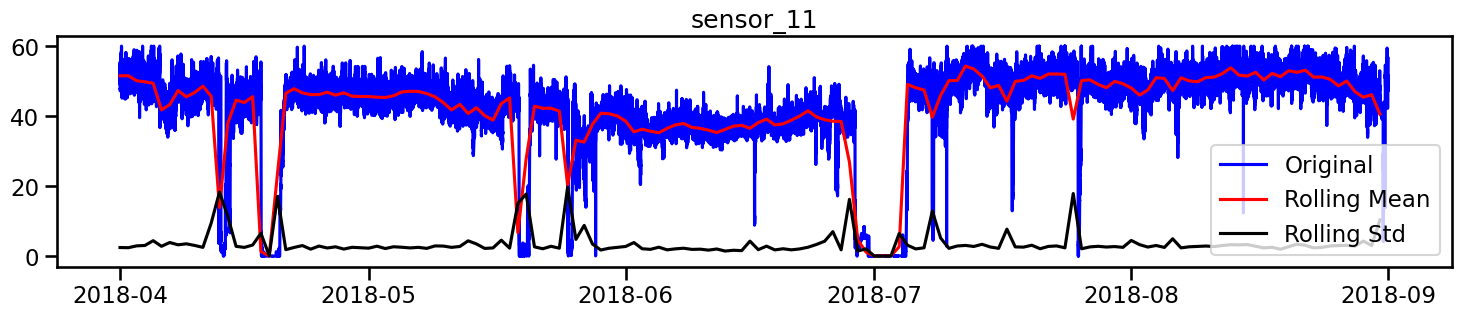

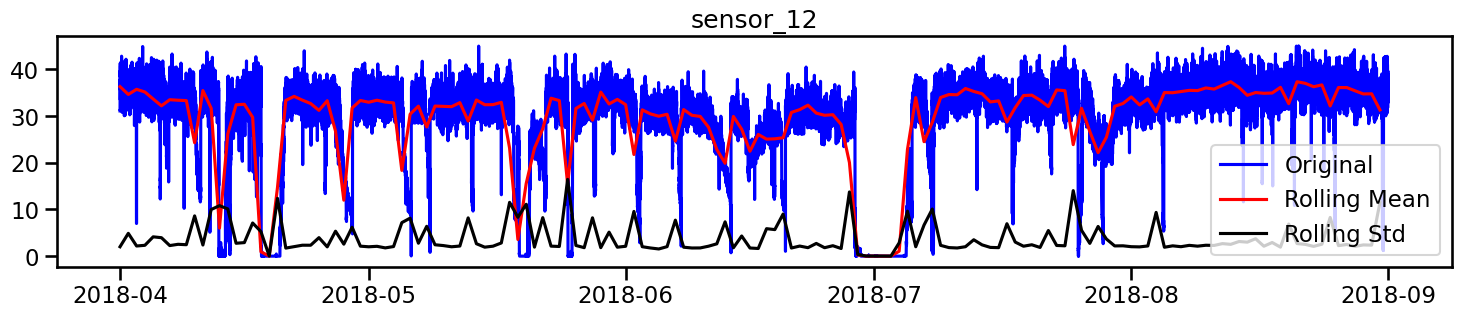

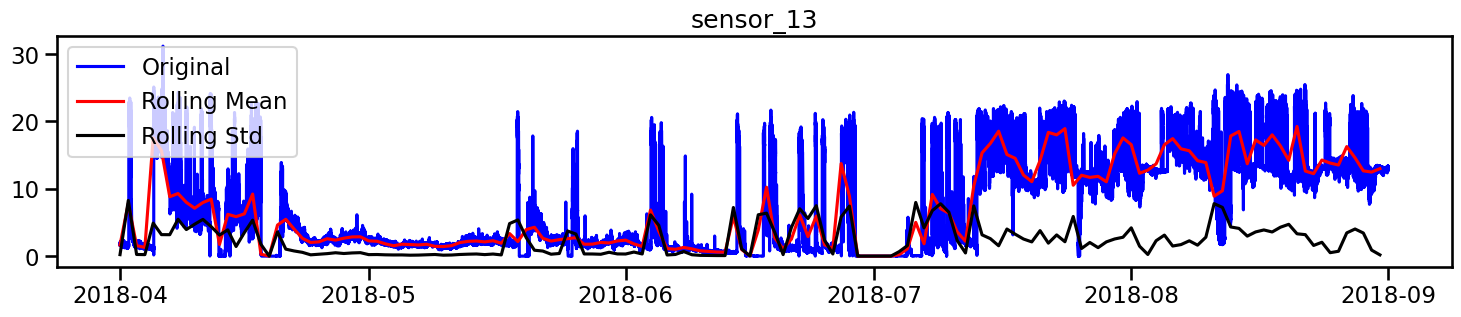

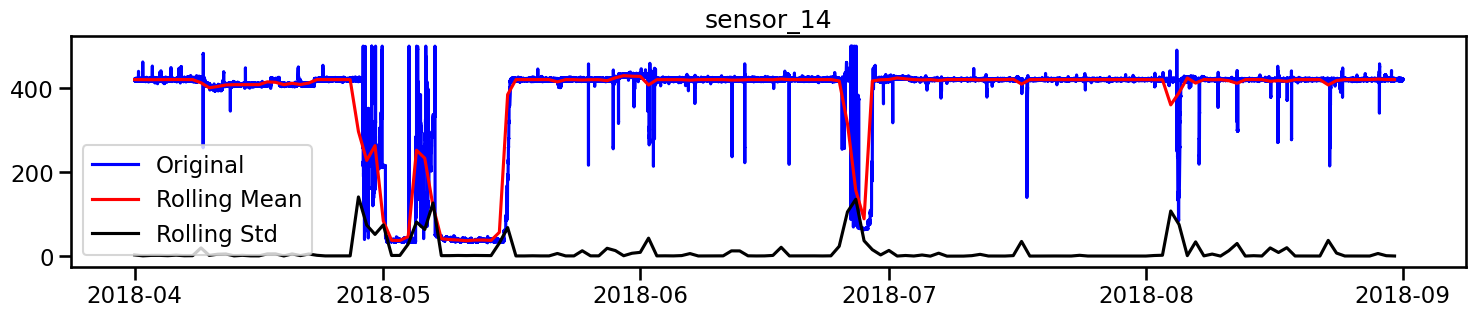

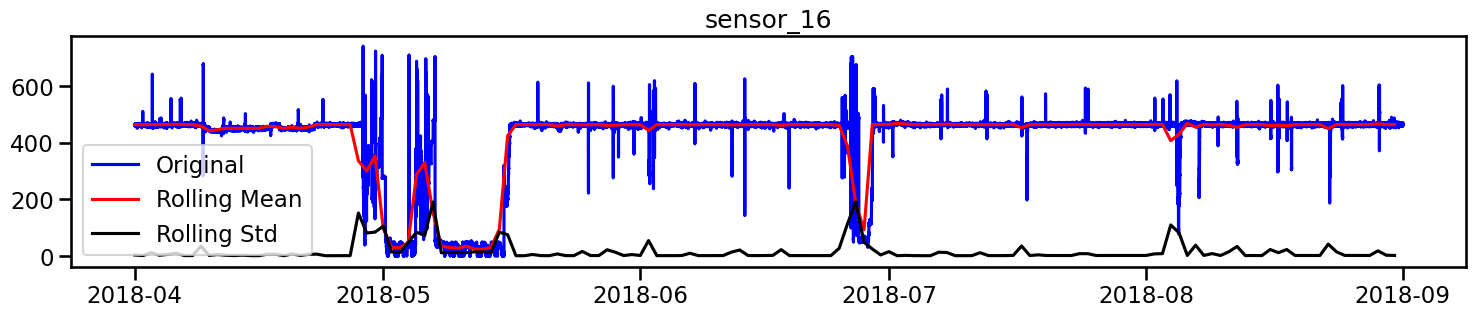

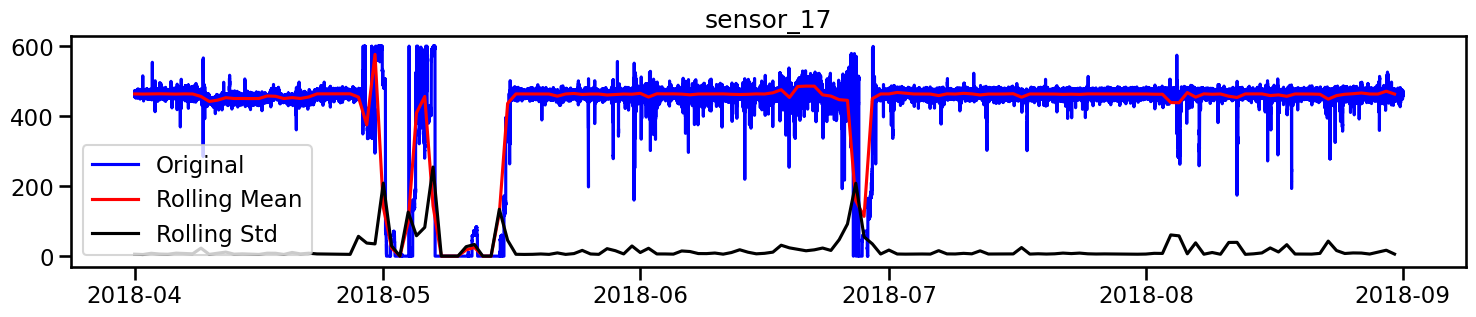

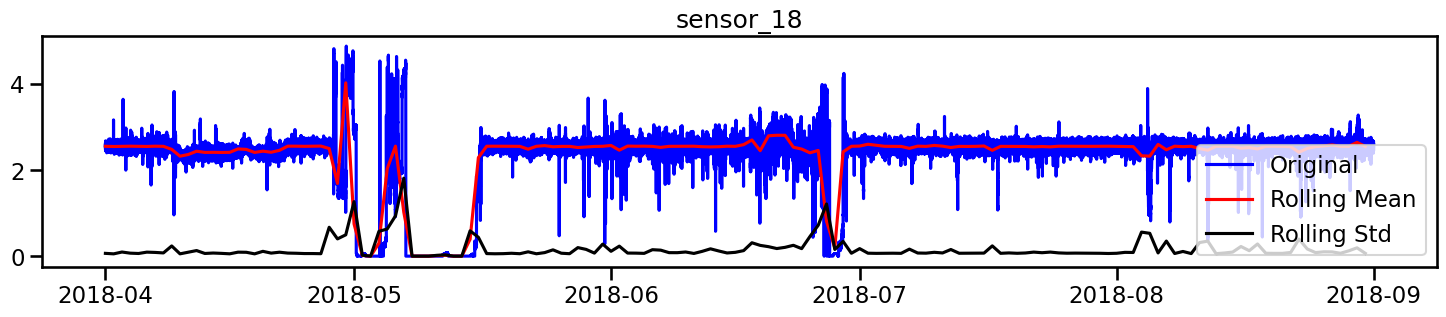

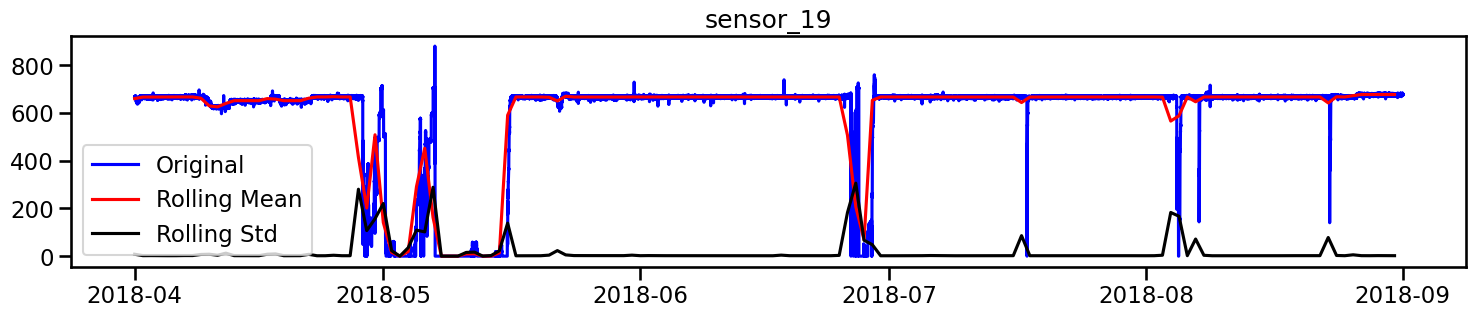

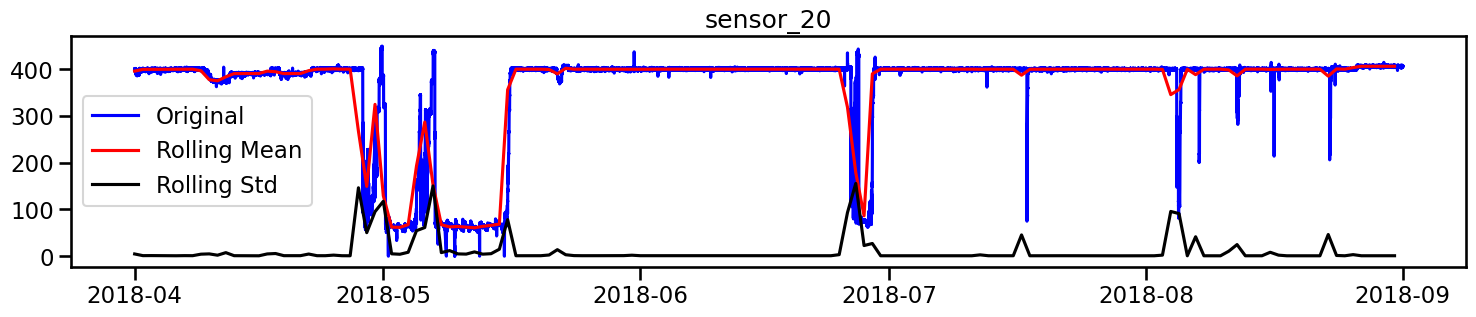

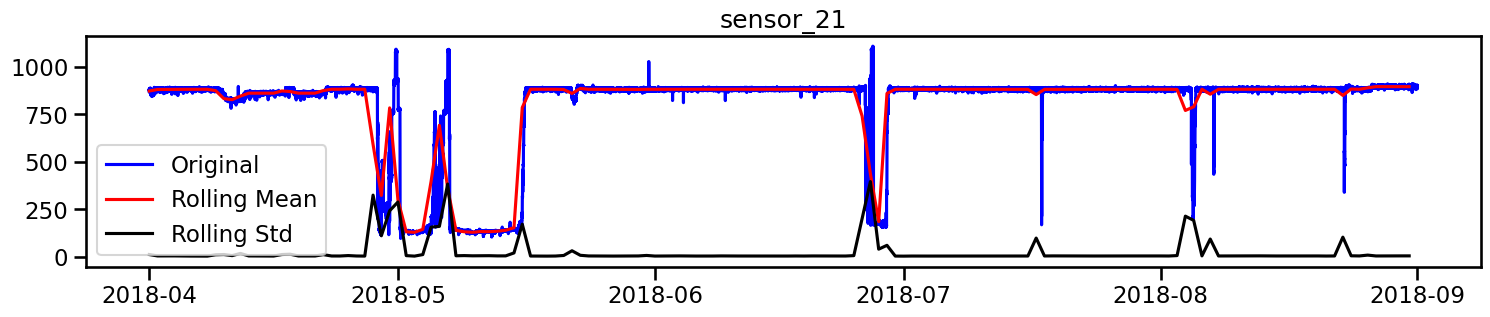

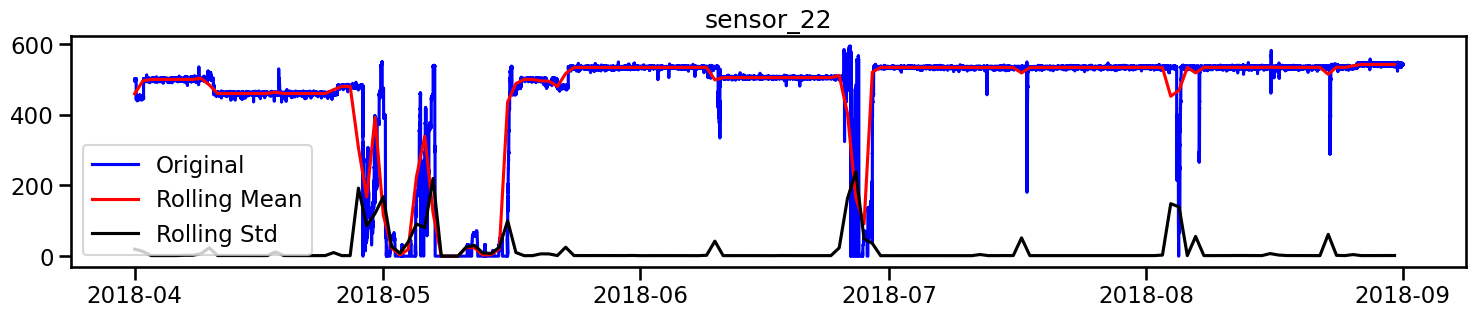

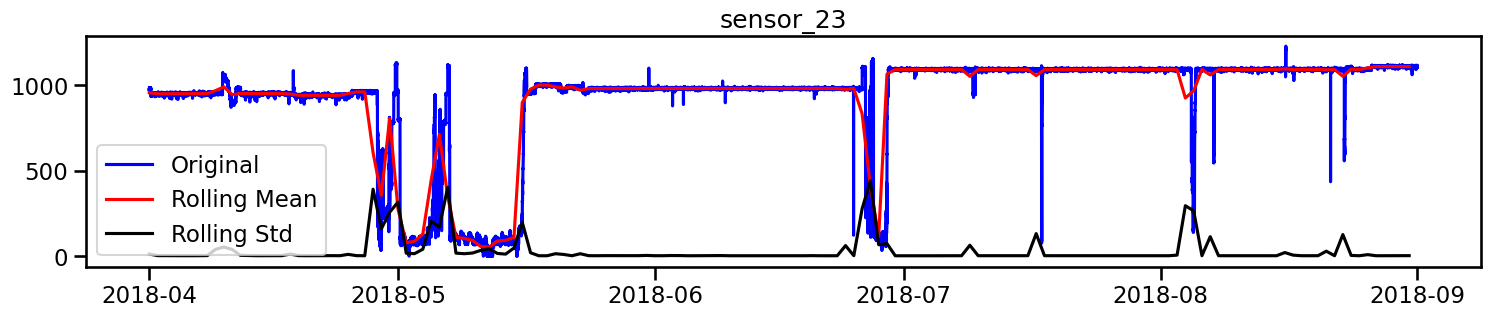

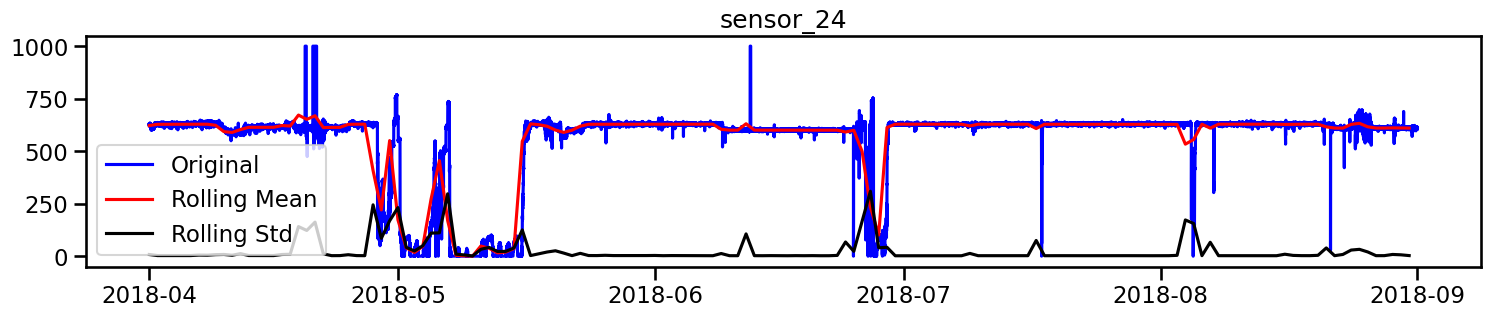

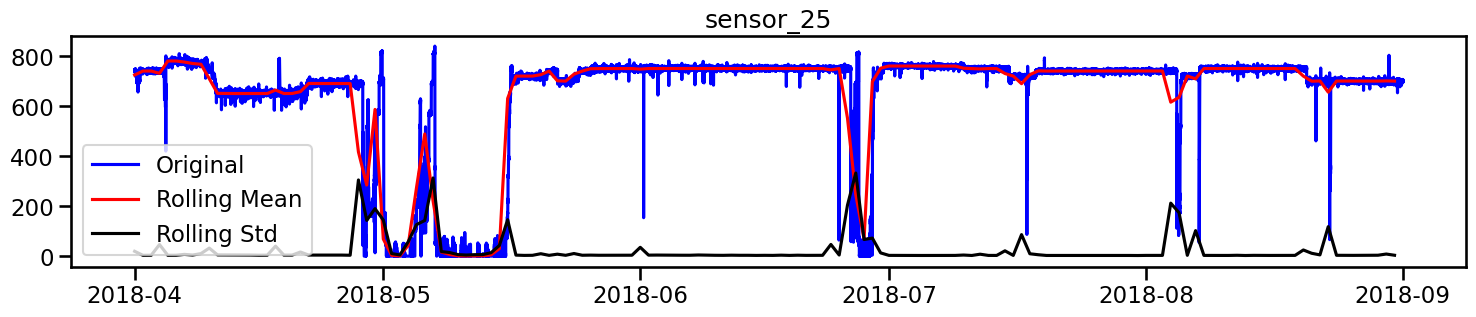

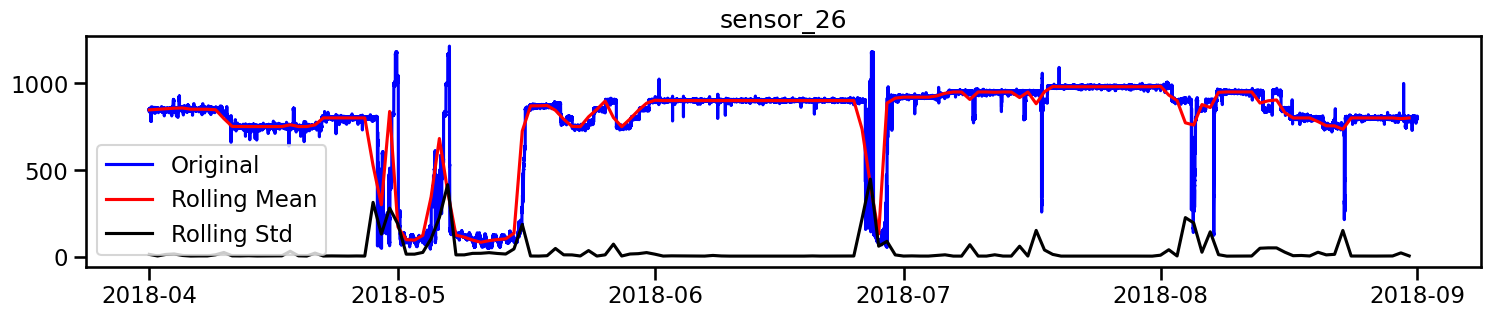

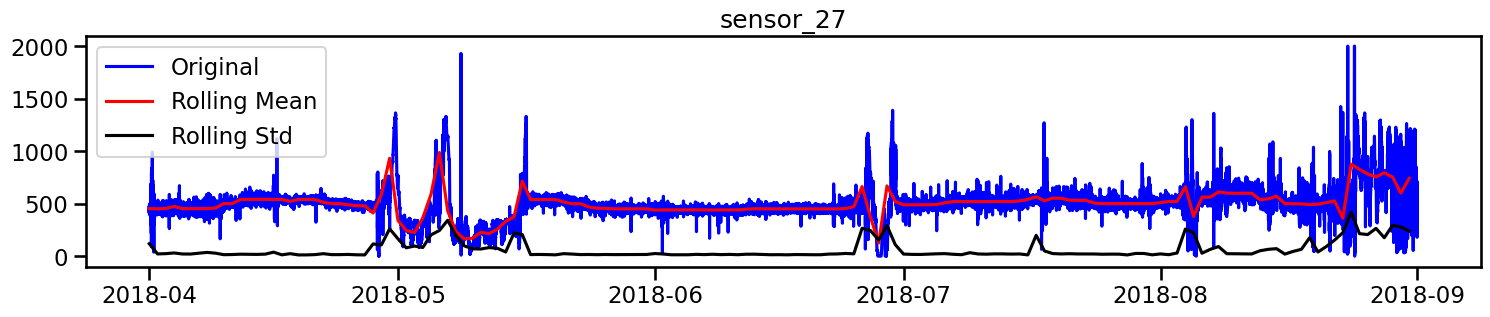

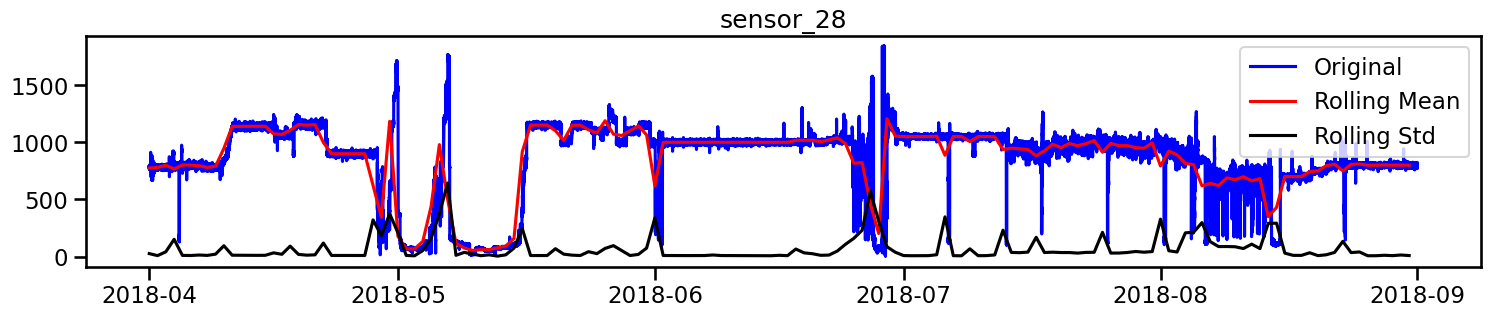

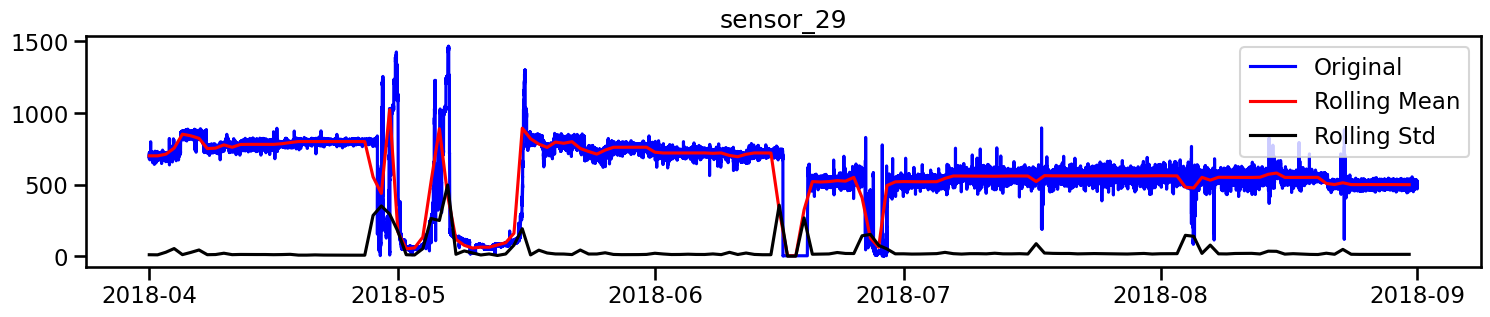

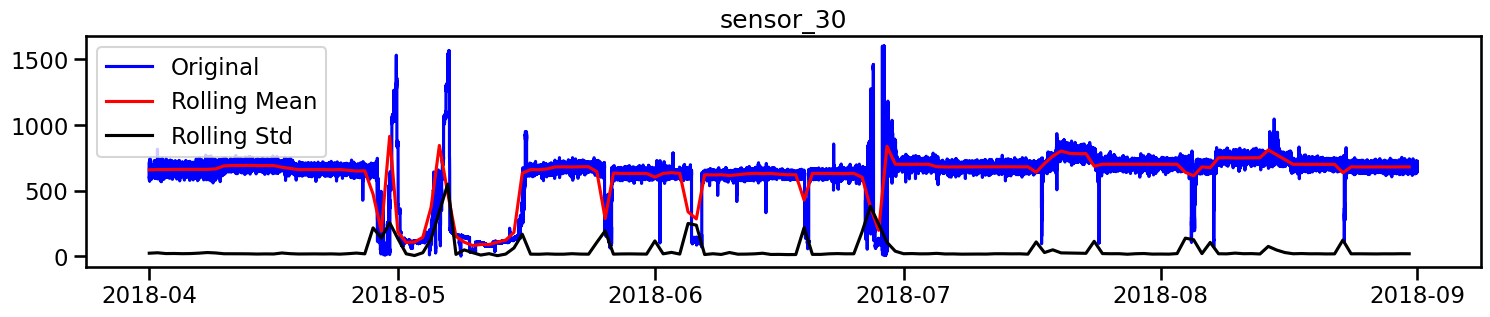

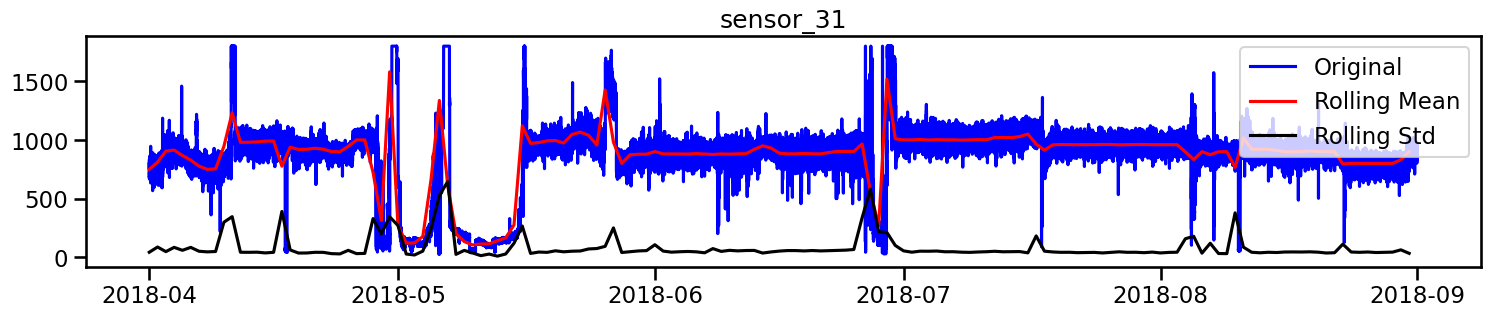

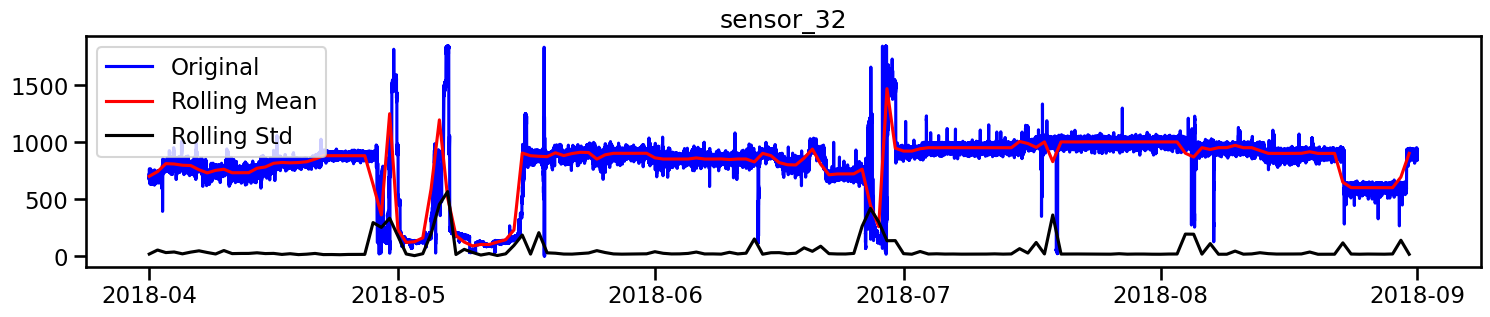

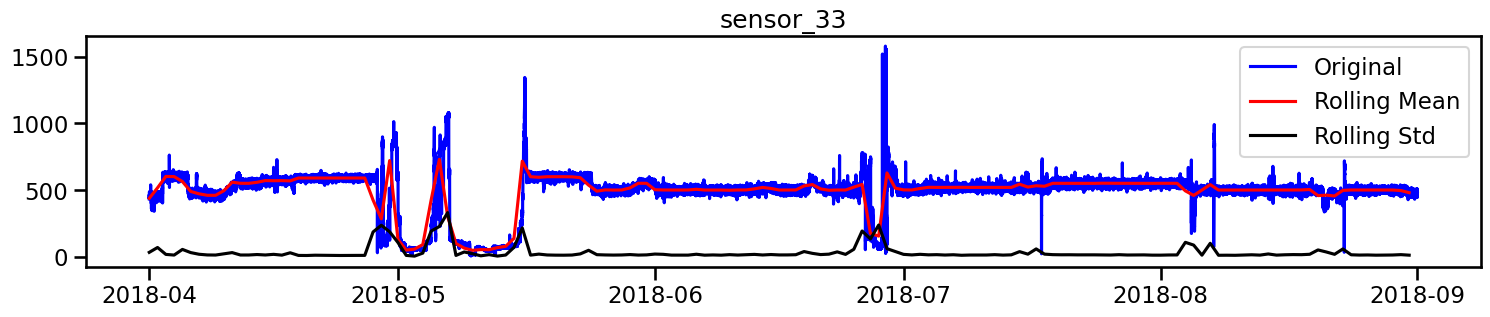

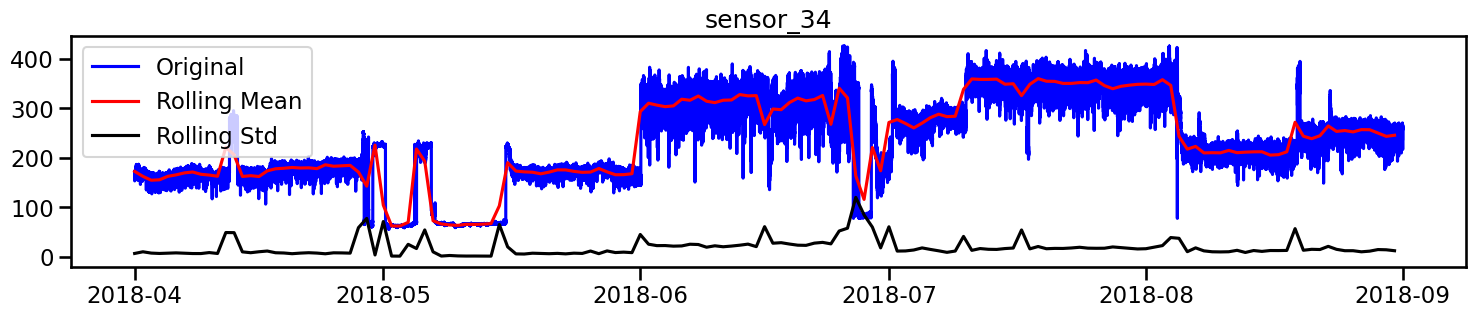

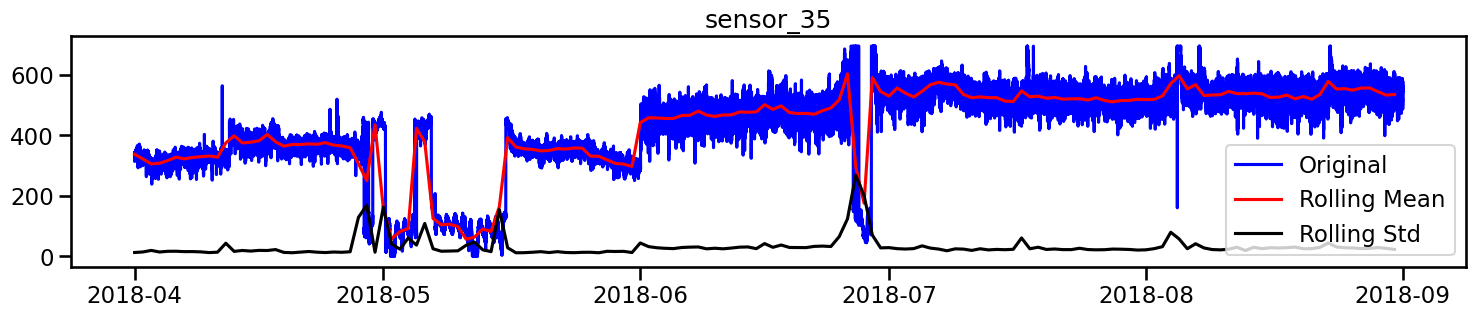

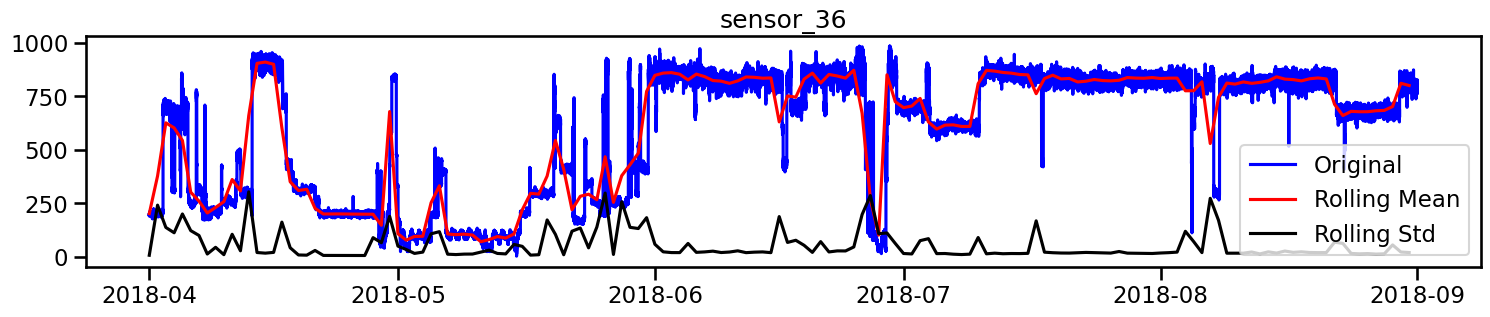

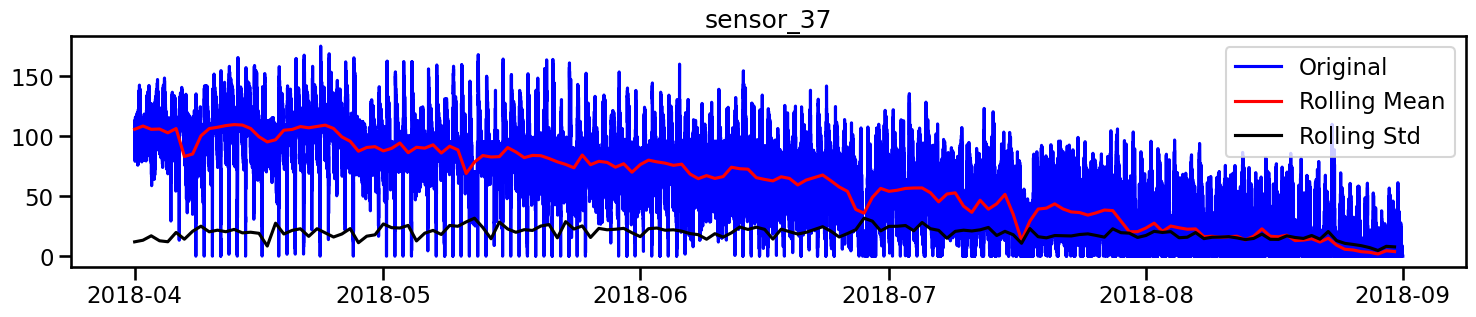

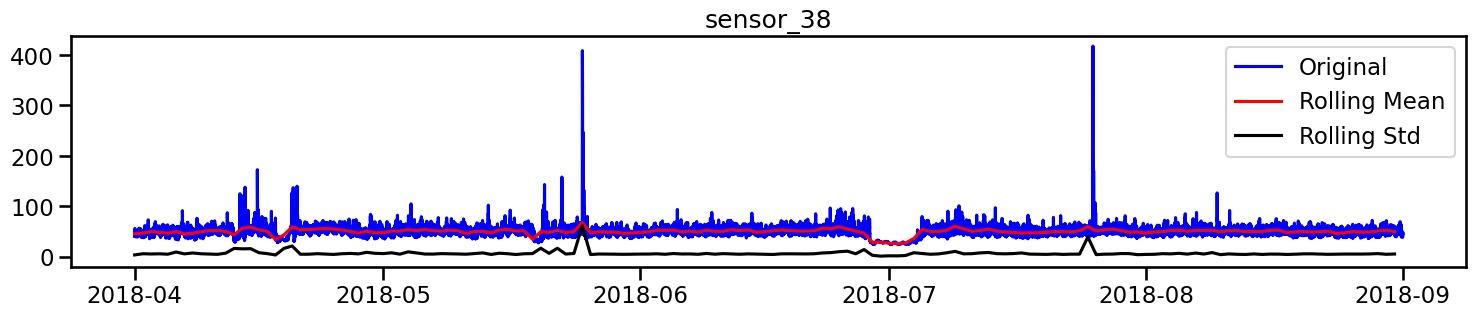

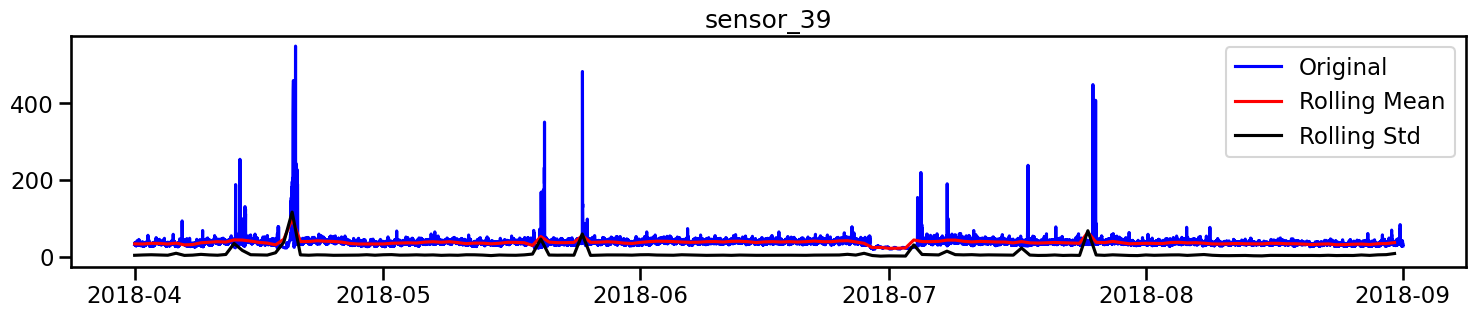

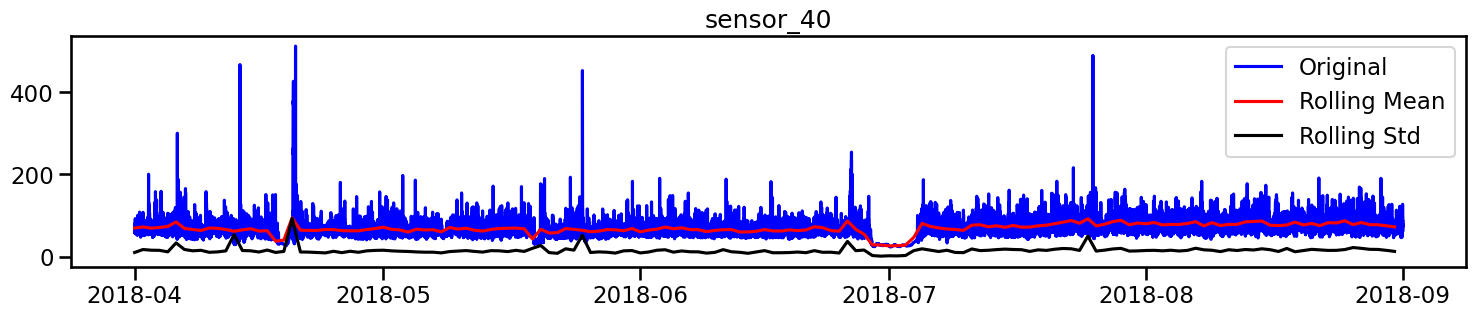

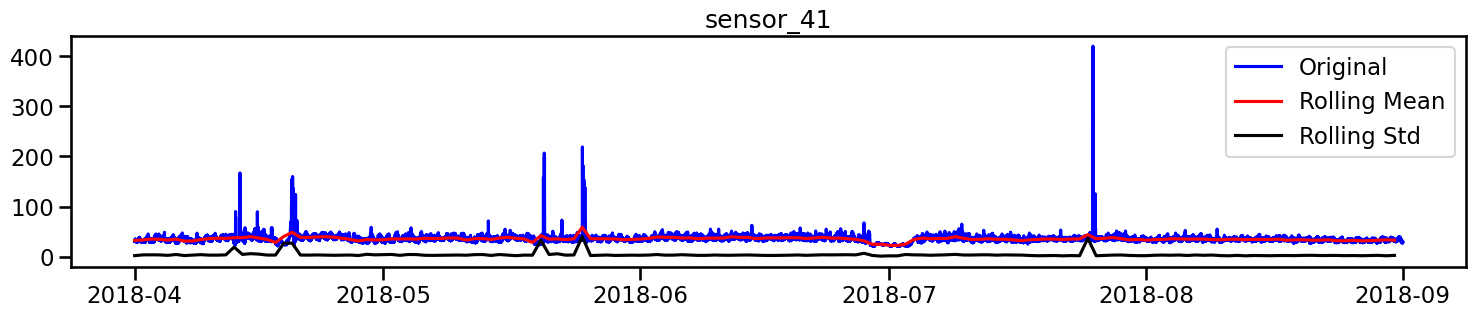

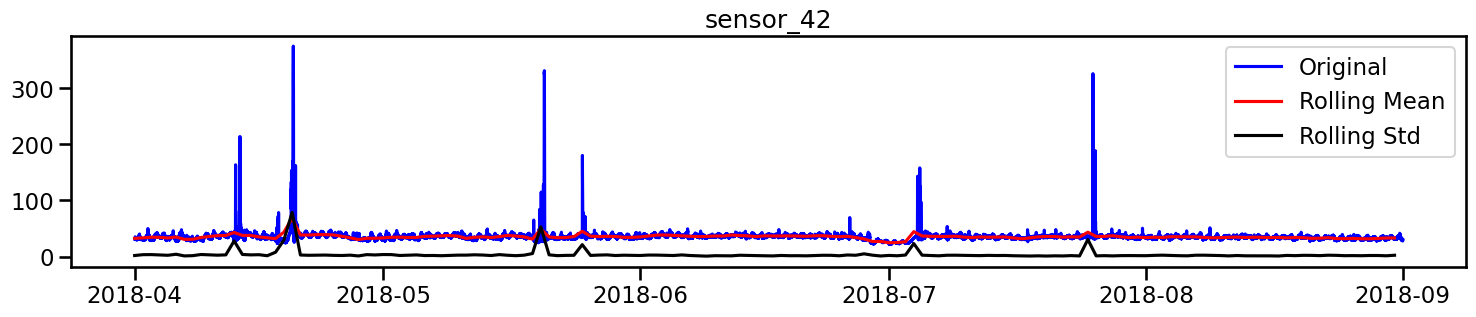

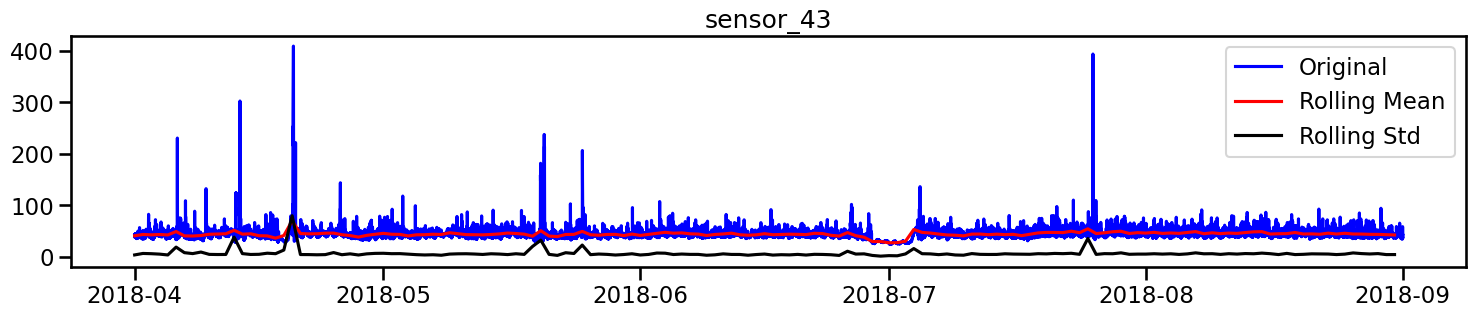

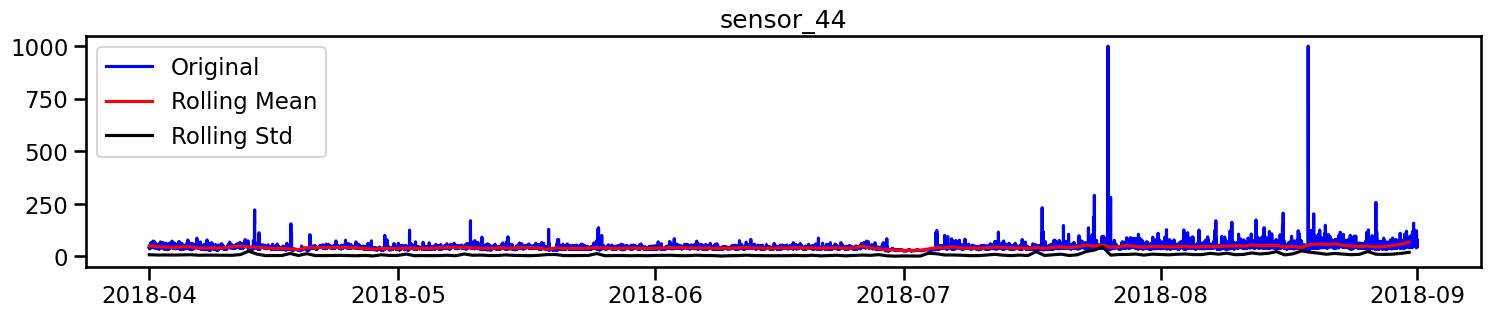

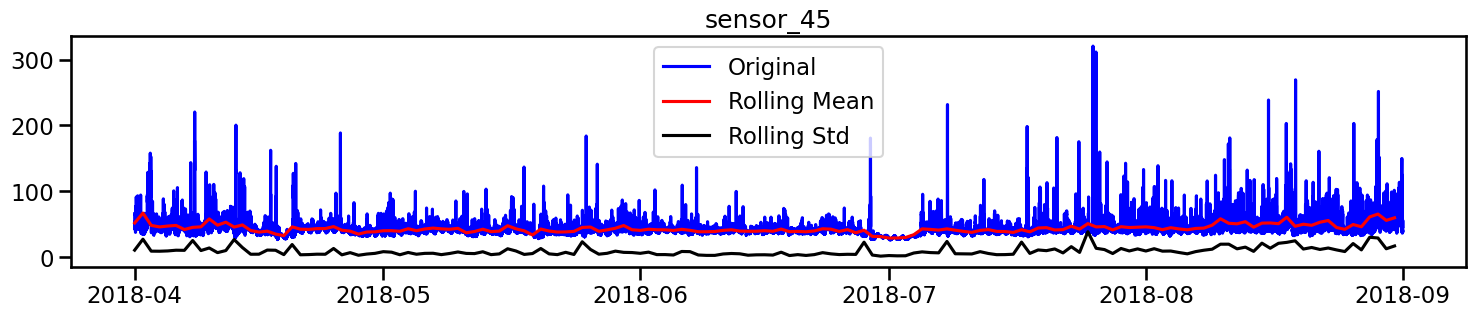

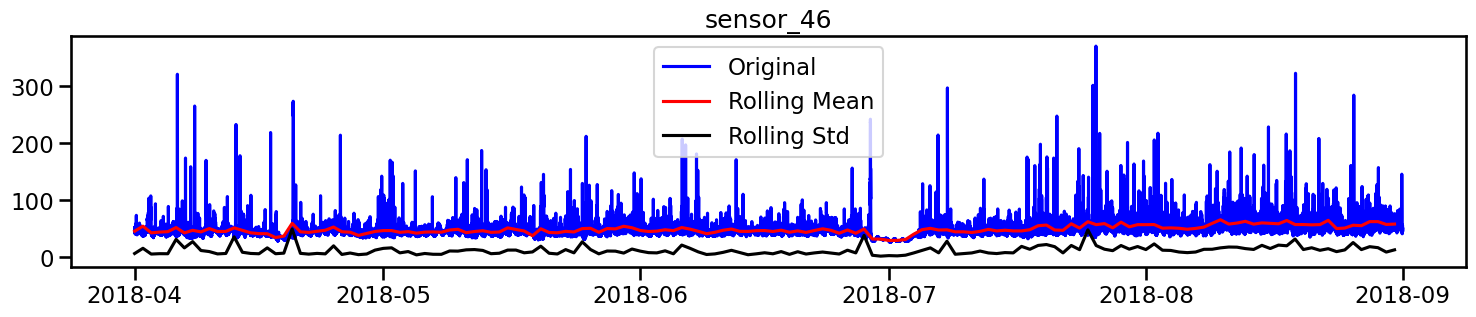

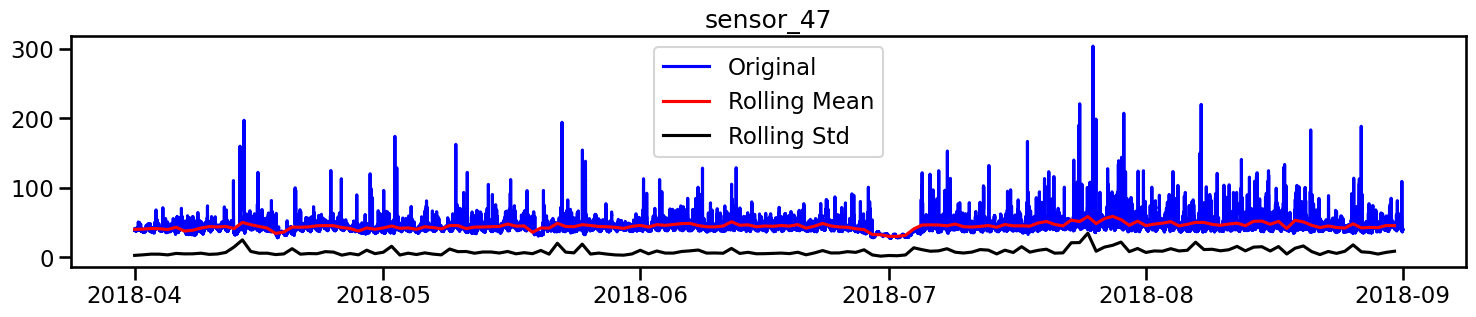

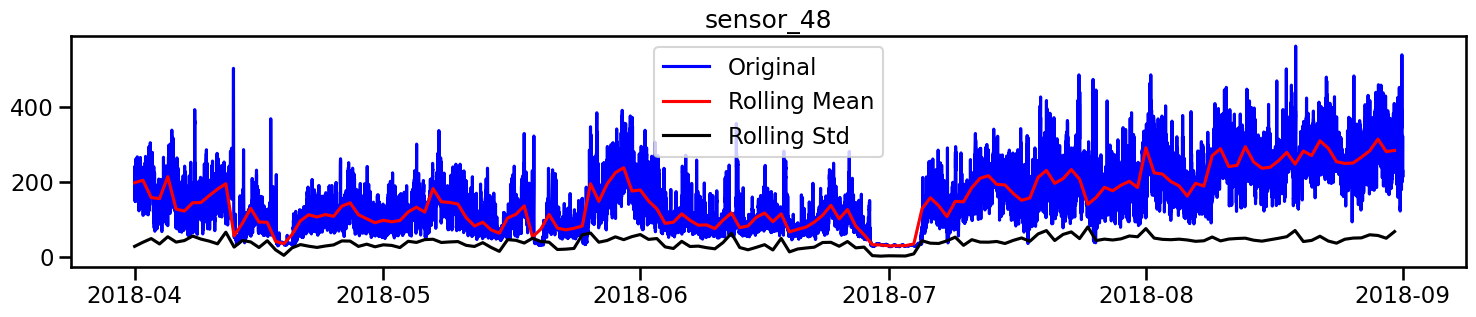

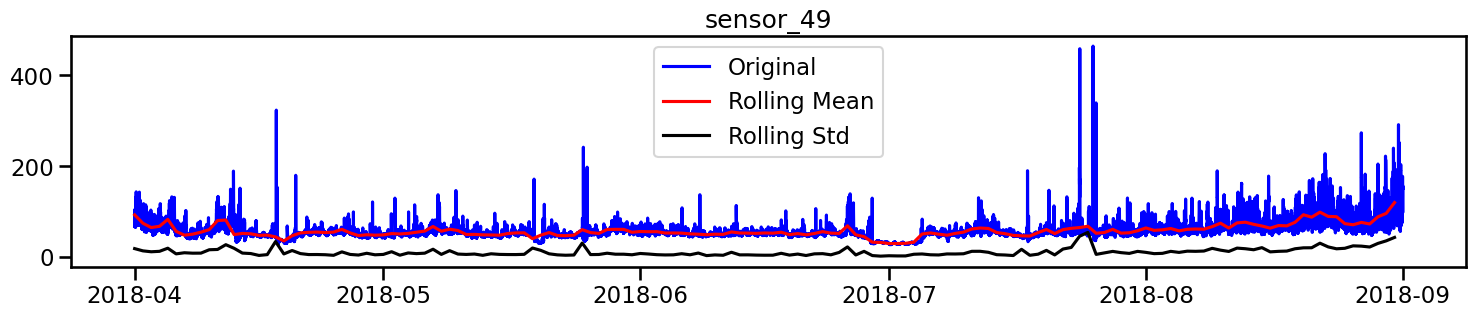

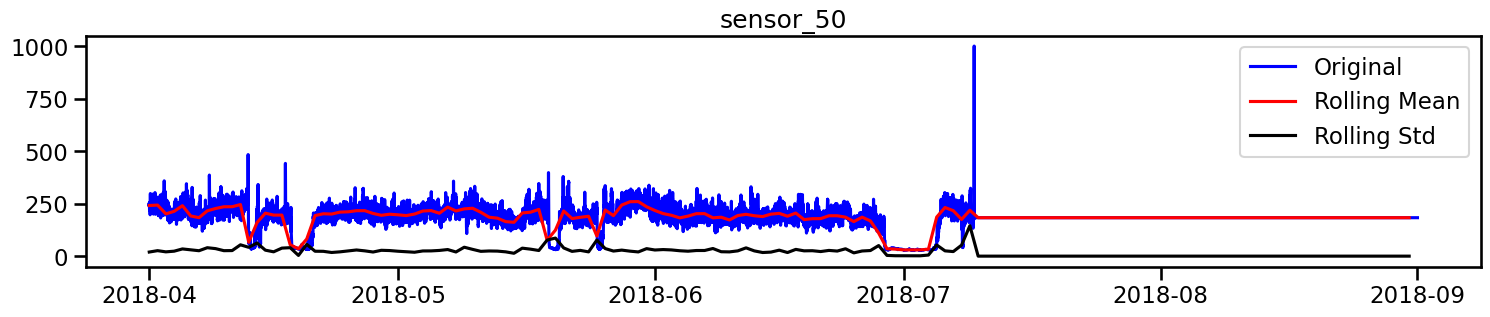

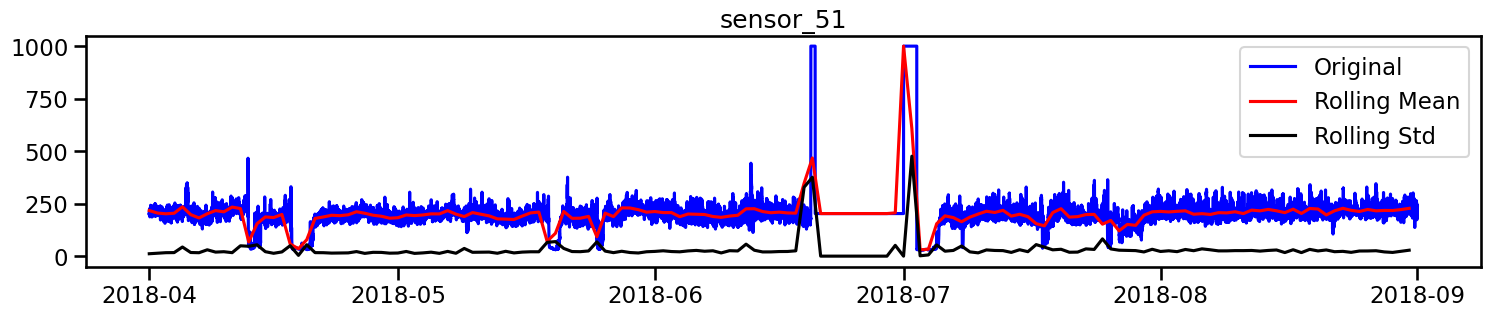

In [18]:
# Resample the entire dataset by daily average
rollmean = df.resample(rule='D').mean()
rollstd = df.resample(rule='D').std()
# Plot time series for each sensor with BROKEN state marked with X in red color
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df[name], color='blue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

### Step 4: Pre-processing and Feature Engineering
In this step, I will scale the data and apply Principal Component Analysis (PCA) to extract the most important features to be further used in training models. It is computationally quite expensive to process the data of this size, (219521, 53), hence the reason for reducing the dimensionality with PCA.

In [19]:
# Standardize/scale the dataset and apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns
df2 = df.drop(['machine_status'], axis=1)
names=df2.columns
x = df[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

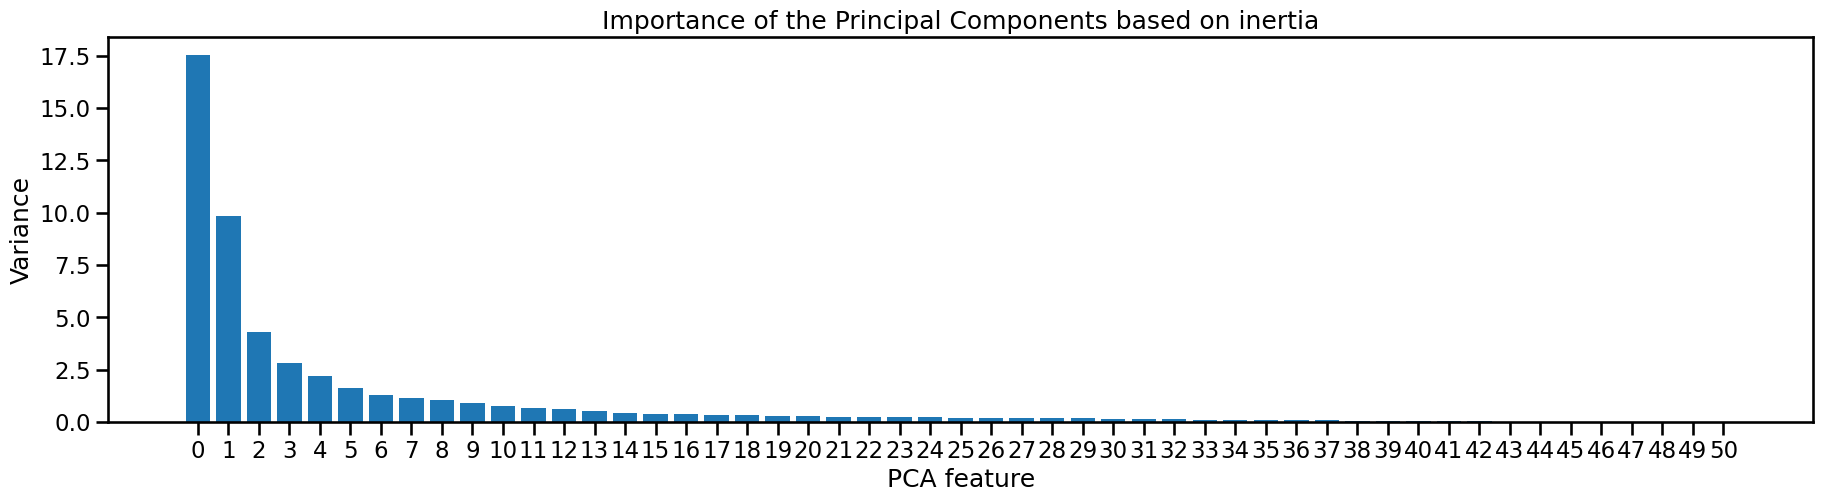

In [20]:
features = range(pca.n_components_)
_ = plt.figure(figsize=(22, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [21]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
df['pc1']=pd.Series(principalDf['pc1'].values, index=df.index)
df['pc2']=pd.Series(principalDf['pc2'].values, index=df.index)
df.head()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
date                                                                         
2018-04-01 00:00:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:01:00   2.465394   47.09201    53.2118  46.310760   634.3750   
2018-04-01 00:02:00   2.444734   47.35243    53.2118  46.397570   638.8889   
2018-04-01 00:03:00   2.460474   47.09201    53.1684  46.397568   628.1250   
2018-04-01 00:04:00   2.445718   47.13541    53.2118  46.397568   636.4583   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
date                                                                         
2018-04-01 00:00:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:01:00   76.45975   13.41146   16.13136   15.56713   15.05353   
2018-04-01 00:02:00   73.54598   13.32465   16.03733   15.61777   15.01013   
2018-04-01 00:03:00   76.98898   13.31742   16.24711   15.69734   15.08247   
2018-04-01 00:04:00   76.58897   13.35359   16.21094   15.69734   15.08247   

                     sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  \
date                                                                         
2018-04-01 00:00:00   37.22740   47.52422   31.11716   1.681353   419.5747   
2018-04-01 00:01:00   37.22740   47.52422   31.11716   1.681353   419.5747   
2018-04-01 00:02:00   37.86777   48.17723   32.08894   1.708474   420.8480   
2018-04-01 00:03:00   38.57977   48.65607   31.67221   1.579427   420.7494   
2018-04-01 00:04:00   39.48939   49.06298   31.95202   1.683831   419.8926   

                     sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
date                                                                         
2018-04-01 00:00:00   461.8781   466.3284   2.565284   665.3993   398.9862   
2018-04-01 00:01:00   461.8781   466.3284   2.565284   665.3993   398.9862   
2018-04-01 00:02:00   462.7798   459.6364   2.500062   666.2234   399.9418   
2018-04-01 00:03:00   462.8980   460.8858   2.509521   666.0114   399.1046   
2018-04-01 00:04:00   461.4906   468.2206   2.604785   663.2111   400.5426   

                     sensor_21  sensor_22  sensor_23  sensor_24  sensor_25  \
date                                                                         
2018-04-01 00:00:00   880.0001   498.8926   975.9409   627.6740   741.7151   
2018-04-01 00:01:00   880.0001   498.8926   975.9409   627.6740   741.7151   
2018-04-01 00:02:00   880.4237   501.3617   982.7342   631.1326   740.8031   
2018-04-01 00:03:00   878.8917   499.0430   977.7520   625.4076   739.2722   
2018-04-01 00:04:00   882.5874   498.5383   979.5755   627.1830   737.6033   

                     sensor_26  sensor_27  sensor_28  sensor_29  sensor_30  \
date                                                                         
2018-04-01 00:00:00   848.0708   429.0377   785.1935   684.9443   594.4445   
2018-04-01 00:01:00   848.0708   429.0377   785.1935   684.9443   594.4445   
2018-04-01 00:02:00   849.8997   454.2390   778.5734   715.6266   661.5740   
2018-04-01 00:03:00   847.7579   474.8731   779.5091   690.4011   686.1111   
2018-04-01 00:04:00   846.9182   408.8159   785.2307   704.6937   631.4814   

                     sensor_31  sensor_32  sensor_33  sensor_34  sensor_35  \
date                                                                         
2018-04-01 00:00:00   682.8125   680.4416   433.7037   171.9375   341.9039   
2018-04-01 00:01:00   682.8125   680.4416   433.7037   171.9375   341.9039   
2018-04-01 00:02:00   721.8750   694.7721   441.2635   169.9820   343.1955   
2018-04-01 00:03:00   754.6875   683.3831   446.2493   166.4987   343.9586   
2018-04-01 00:04:00   766.1458   702.4431   433.9081   164.7498   339.9630   

                     sensor_36  sensor_37  sensor_38  sensor_39  sensor_40  \
date                                                                         
2018-04-01 00:00:00   195.0655   90.

#### Check stationarity with Dickey-Fuller Test

In [22]:

from statsmodels.tsa.stattools import adfuller
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc1'])
# Print p-value
print(result[1])

5.4536849418487954e-05


In [23]:
# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc2'])
# Print p-value
print(result[1])

1.8909142448446991e-06


#### Check for Autocorrelation

Autocorrelation is:  -0.002051194822630667


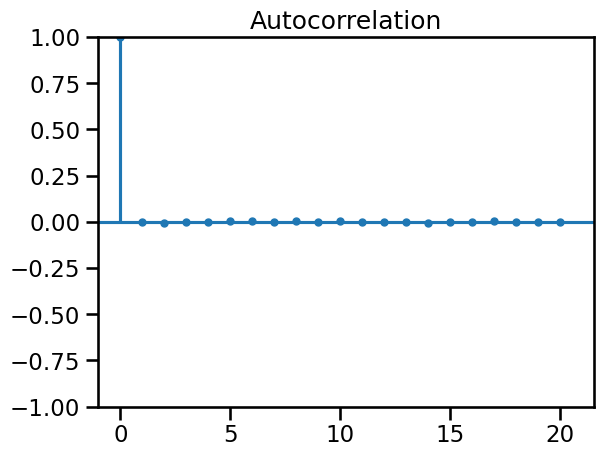

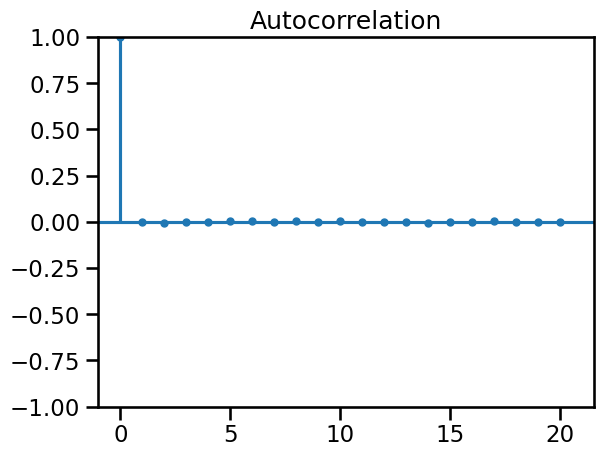

In [24]:
# Compute change in daily mean 
pca1 = principalDf['pc1'].pct_change()
# Compute autocorrelation
autocorrelation = pca1.dropna().autocorr()
print('Autocorrelation is: ', autocorrelation)

# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pca1.dropna(), lags=20, alpha=0.05)

### Step 5: Modelling 
Base Model: Detect Outliers Using the Interquartile Range (IQR)
Anomalies are defined as rare events that could be represented by the outliers in the data set. As an initial step, I want to apply a basic statistics technique to get the feel of the outliers present in this data set. Later, I will compare the results of the other models to the results from the Base Model for further model evaluation.

0: normal

1: anomaly

In [25]:
# outlier_lower = Q1 - (1.5*IQR)
# outlier_upper = Q3 + (1.5*IQR)
# Calculate outlier bounds for pc1
q1_pc1, q3_pc1 = df['pc1'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
# Calculate outlier bounds for pc2
q1_pc2, q3_pc2 = df['pc2'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
lower_pc2 = q1_pc2 - (1.5*iqr_pc2)
upper_pc2 = q3_pc2 + (1.5*iqr_pc2)

df['anomaly_pc1'] = ((df['pc1']>upper_pc1) | (df['pc1']<lower_pc1)).astype('int')
df['anomaly_pc2'] = ((df['pc2']>upper_pc2) | (df['pc2']<lower_pc2)).astype('int')
print('Anomaly count with PC1\n ',df['anomaly_pc1'].value_counts())
print('\nAnomaly count with PC2\n ',df['anomaly_pc2'].value_counts())


outliers_pc1 = df.loc[(df['pc1']>upper_pc1) | (df['pc1']<lower_pc1), 'pc1']
outliers_pc2 = df.loc[(df['pc2']>upper_pc2) | (df['pc2']<lower_pc2), 'pc2']

Anomaly count with PC1
  0    189644
1     29877
Name: anomaly_pc1, dtype: int64

Anomaly count with PC2
  0    217947
1      1574
Name: anomaly_pc2, dtype: int64


Now I want to select the most important 3 features in the data set to detect anomalies in them. To find out these features, I will use Univariate feature selection technique.

In [26]:
# Apply SelectKBest class to extract the best 3 features - Univariate feature selection 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
x = df.drop(['machine_status', 'pc1', 'pc2', 'anomaly_pc1', 'anomaly_pc2'], axis=1)
y = df['machine_status']
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(x_scaled, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(3, 'Score'))

      Feature         Score
11  sensor_11  10106.761967
12  sensor_12   9879.052739
4   sensor_04   8167.176442


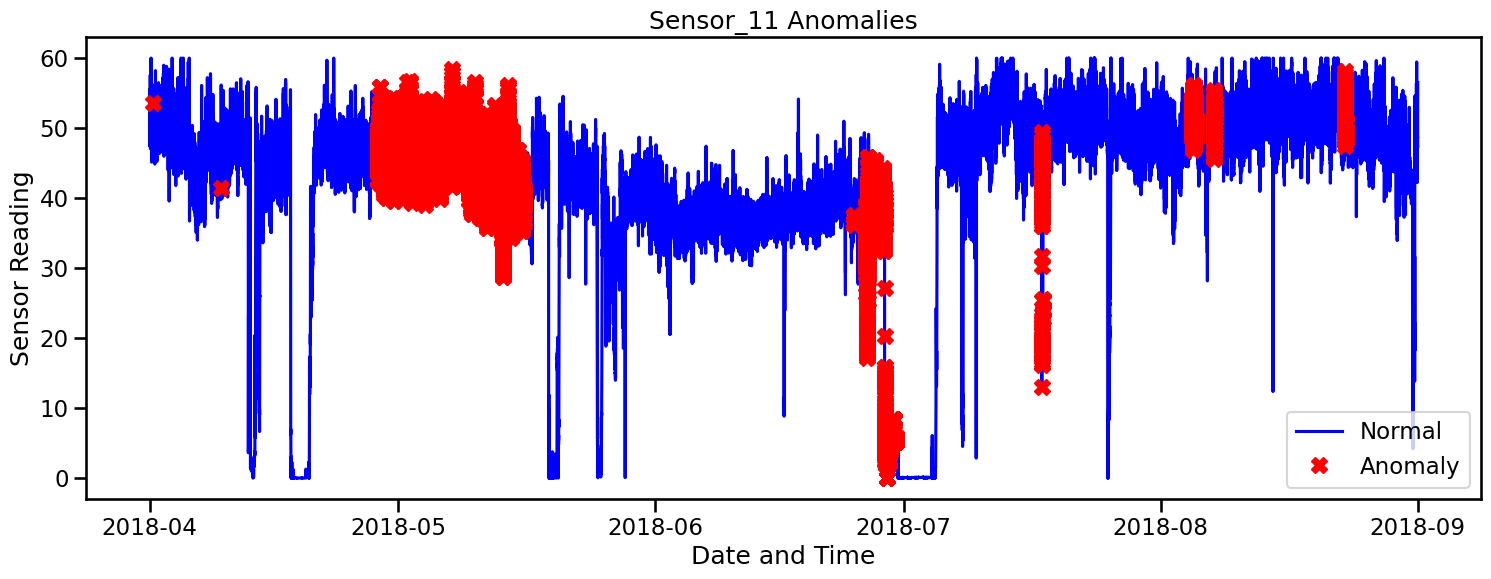

In [27]:
# Let's plot the outliers from pc1 on top of the sensor_11 see where they occured in the time series
a = df[df['anomaly_pc1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='blue', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

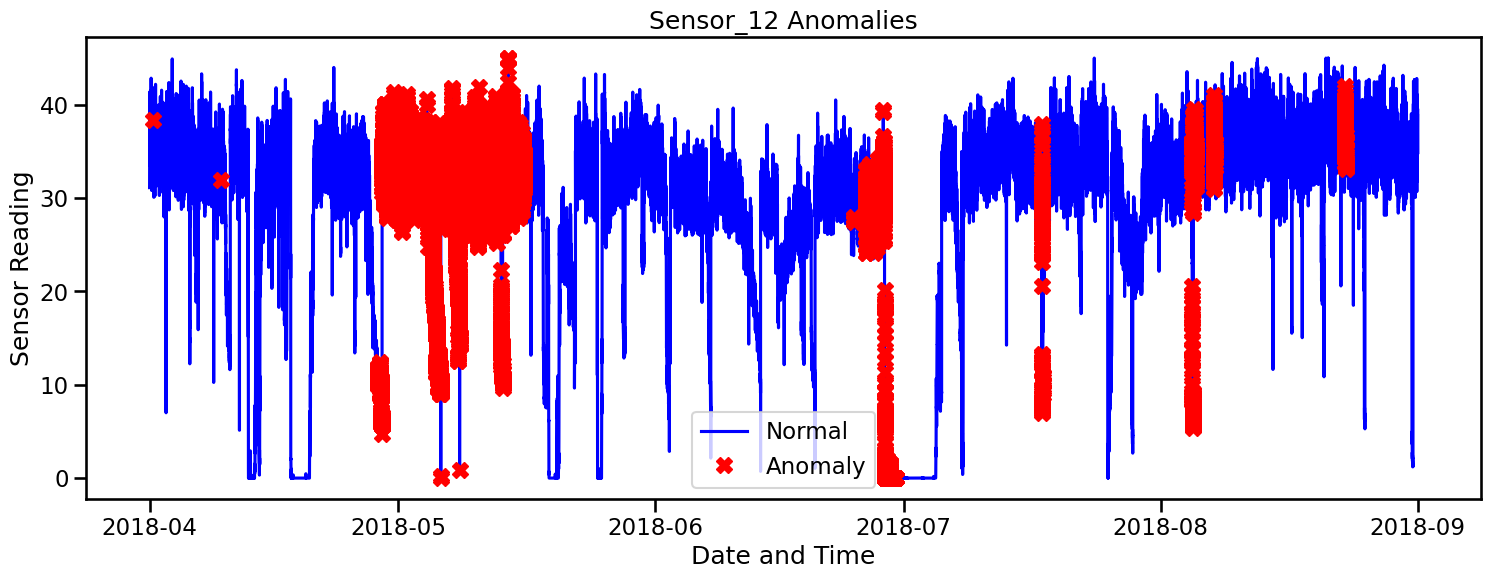

In [28]:
# Let's plot the outliers from pc2 on top of the sensor_00 see where they occured in the time series
a = df[df['anomaly_pc1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_12'], color='blue', label='Normal')
_ = plt.plot(a['sensor_12'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_12 Anomalies')
_ = plt.legend(loc='best')
plt.show();

## Model : K-means clustering
Strategy:

The underline assumption in the clustering based anomaly detection is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters. We use the following steps to find and visualize anomalies.

Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.
We use outliers_fraction to provide information to the algorithm about the proportion of the outliers present in our data set. Situations may vary from data set to data set. However, as a starting figure, I estimate outliers_fraction=0.14 (14% of df are outliers as depicted above).
Calculate number_of_outliers using outliers_fraction.
Set threshold as the minimum distance of these outliers.
The anomaly result of anomaly1 contains the above method Cluster (0:normal, 1:anomaly).
Visualize anomalies with cluster view.
Visualize anomalies with Time Series view.

In [29]:
# Import necessary libraries
from sklearn.cluster import KMeans
# I will start k-means clustering with k=2 as I already know that there are 3 classes of "NORMAL" vs 
# "NOT NORMAL" which are combination of BROKEN" and"RECOVERING"
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(principalDf.values)
labels = kmeans.predict(principalDf.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

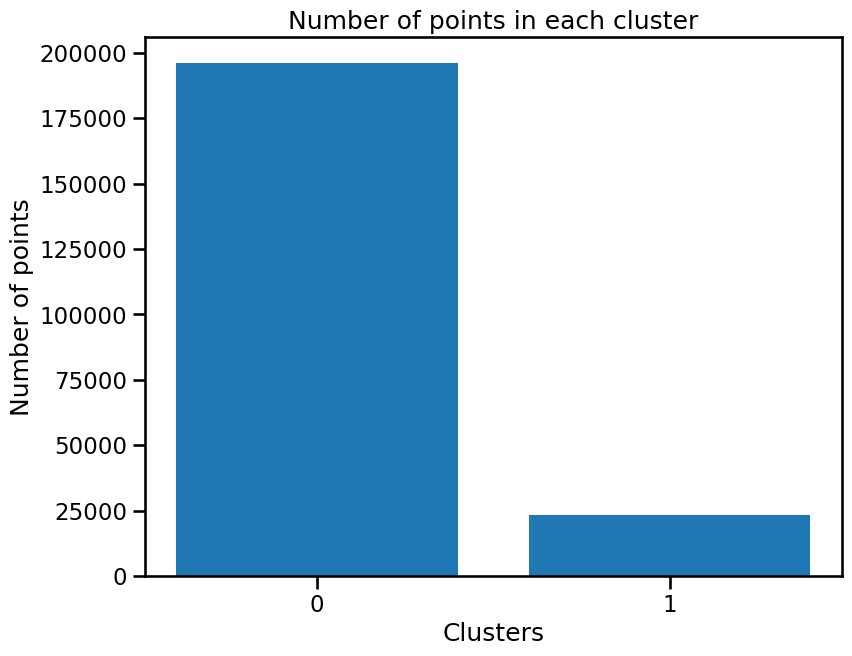

In [30]:
_ = plt.figure(figsize = (9, 7))
_ = plt.bar(clusters[0], clusters[1], tick_label=clusters[0])
_ = plt.xlabel('Clusters')
_ = plt.ylabel('Number of points')
_ = plt.title('Number of points in each cluster')
plt.show()

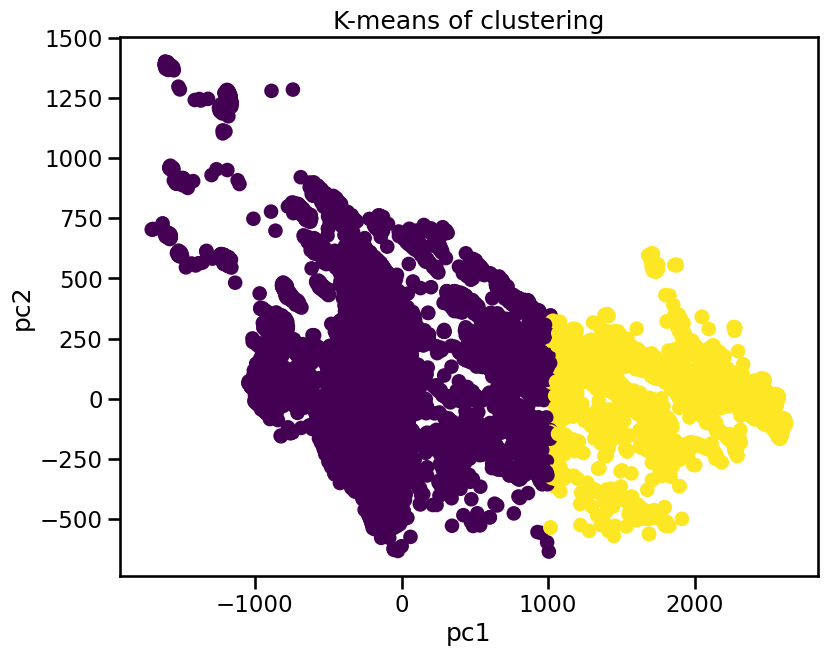

In [31]:
_ = plt.figure(figsize=(9,7))
_ = plt.scatter(principalDf['pc1'], principalDf['pc2'], c=labels)
_ = plt.xlabel('pc1')
_ = plt.ylabel('pc2')
_ = plt.title('K-means of clustering')
plt.show()

In [32]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [33]:
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

In [34]:
principalDf.head()

pc1         pc2  anomaly1
0  72.736850  265.819997         0
1  72.736850  265.819997         0
2  30.802311  283.470003         0
3  27.329130  290.144344         0
4  32.911764  294.766508         0

In [35]:
principalDf['anomaly1'].value_counts()

0    190984
1     28537
Name: anomaly1, dtype: int64

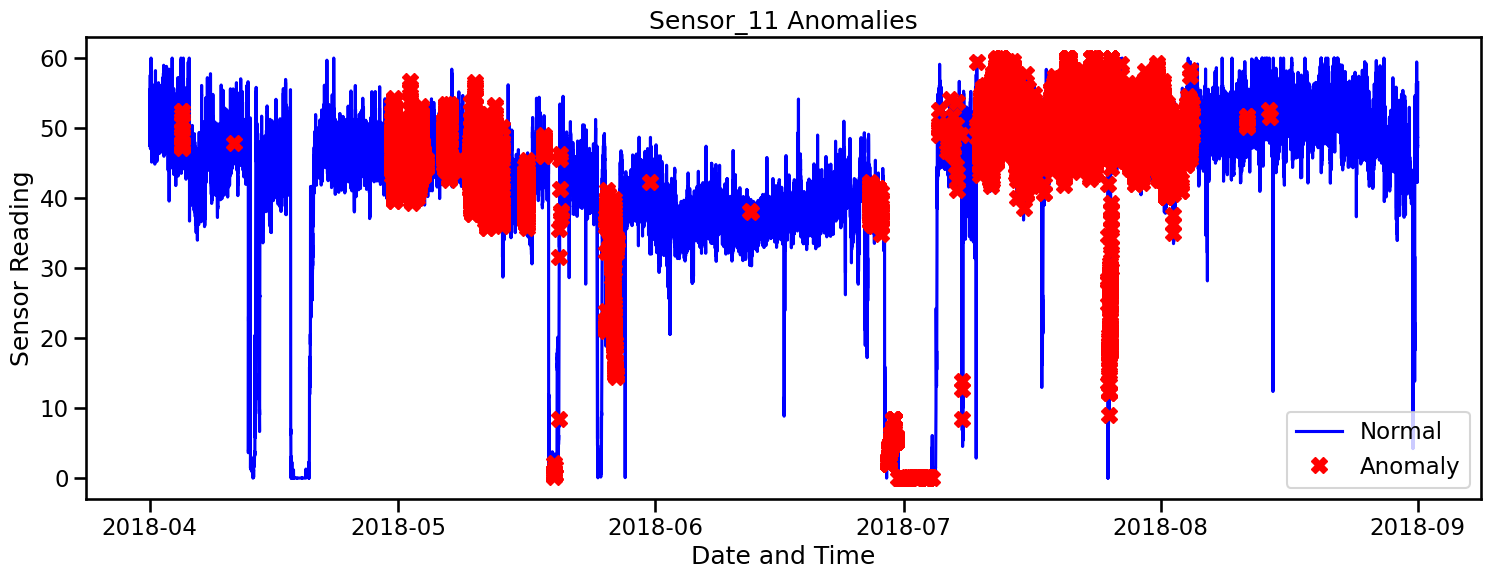

In [36]:
df['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=df.index)
a = df[df['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='blue', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

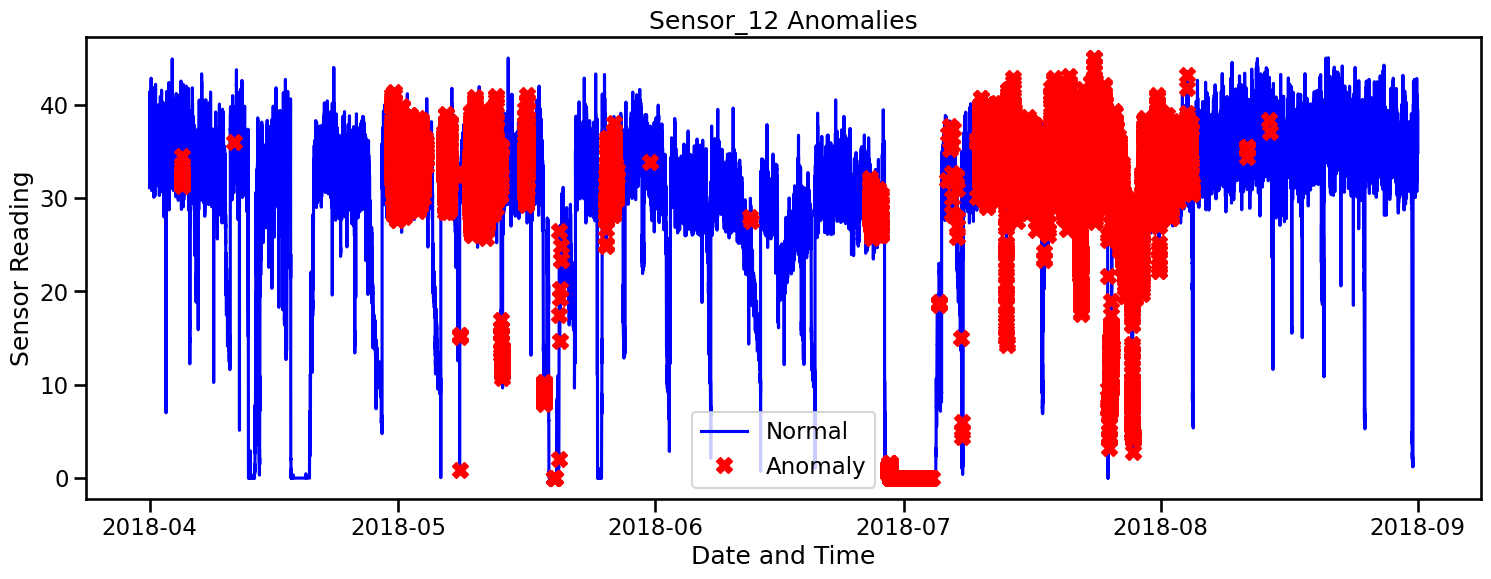

In [37]:
a = df[df['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_12'], color='blue', label='Normal')
_ = plt.plot(a['sensor_12'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_12 Anomalies')
_ = plt.legend(loc='best')
plt.show();

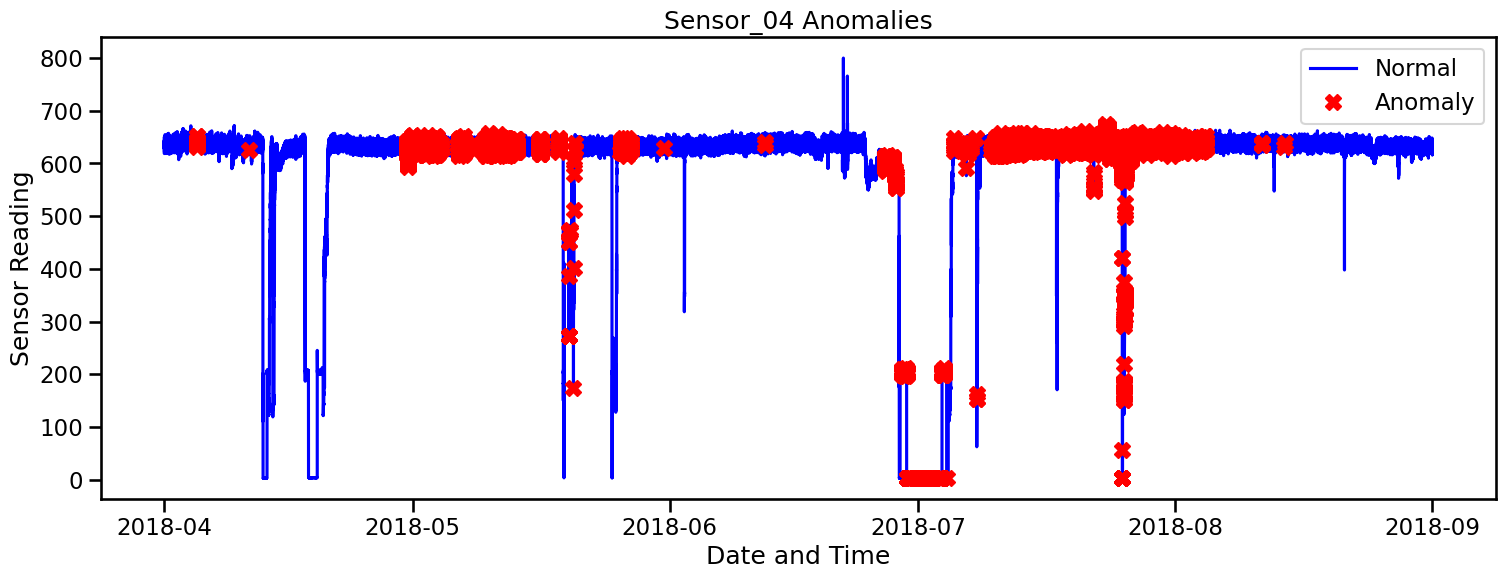

In [38]:
a = df[df['anomaly1'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_04'], color='blue', label='Normal')
_ = plt.plot(a['sensor_04'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_04 Anomalies')
_ = plt.legend(loc='best')
plt.show();

In [39]:
df[df['anomaly1']==1]['machine_status'].value_counts()

NORMAL        26745
RECOVERING     1791
BROKEN            1
Name: machine_status, dtype: int64

In [40]:
df['machine_status'].value_counts()

NORMAL        205067
RECOVERING     14447
BROKEN             7
Name: machine_status, dtype: int64